<center><h1>Основы глубокого обучение</h1></center>

In [11]:
!python -V # Версия Python

Python 3.12.8


In [12]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import os
import io
import socket
import random
import torch
import torch.nn as nn
import torch.optim as optim
import tensorboard as tb
import torchinfo
import numpy as np
import pandas as pd
import polars as pl
import tabulate
import datasets
import torchvision as tv
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import PIL
import jupyterlab as jlab
import ipywidgets
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import tqdm
import logging

from dataclasses import dataclass
from typing import ClassVar

from pathlib import Path
from torch.optim import Adam
from torchvision.transforms import v2
from torchvision import transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datasets import load_dataset_builder, load_dataset, get_dataset_split_names, get_dataset_config_names, Dataset, Image, DatasetInfo
from datetime import datetime
from PIL import Image as PILImage, ImageFont, ImageDraw
from collections import Counter
from torchinfo import summary

from typing import List, Dict, Any, Tuple, Optional

In [13]:
# Версии необходимых библиотек
packages = [
    "Torch", "TorchVision", "TensorBoard", "Torchinfo", "NumPy", "Polars", "Pandas", "Datasets", "Pillow", "Matplotlib",
    "Tqdm", "Tabulate", "Ipywidgets", "JupyterLab"
]

package_objects = [
    torch, tv, tb, torchinfo, np, pl, pd, datasets, PIL, mpl, tqdm, tabulate, ipywidgets, jlab
]

versions = list(map(lambda obj: obj.__version__, package_objects))

columns_order = ["№", "Библиотека", "Версия"]
df_pkgs = (
    pl.DataFrame({
        columns_order[1]: packages,
        columns_order[2]: versions
    })
    .with_columns(pl.arange(1, pl.lit(len(packages)) + 1).alias(columns_order[0]))
    .select(columns_order)
)

display(df_pkgs)

path2reqs = "."
reqs_name = "requirements.txt"

def get_packages_and_versions():
    """Генерация строк с библиотеками и их версиями в формате: библиотека==версия"""
    
    for package, version in zip(packages, versions):
        yield f"{package.lower()}=={version}\n"

with open(os.path.join(path2reqs, reqs_name), "w", encoding = "utf-8") as f:
    f.writelines(get_packages_and_versions())

№,Библиотека,Версия
i64,str,str
1,"""Torch""","""2.2.2"""
2,"""TorchVision""","""0.17.2"""
3,"""TensorBoard""","""2.18.0"""
4,"""Torchinfo""","""1.8.0"""
5,"""NumPy""","""1.26.4"""
…,…,…
10,"""Matplotlib""","""3.10.0"""
11,"""Tqdm""","""4.67.1"""
12,"""Tabulate""","""0.9.0"""


# Лекция 2

2. **Основы нейросетей**
    - Принципы работы нейросетей: функции активации и потерь, методы оптимизации и механизм обратного распространения ошибки.
    - Роль гиперпараметров и способы их настройки.

## Основы нейросетей

## Перцептрон (один нейрон)

> Фундаментальный строительный блок нейросети.

<div class="d-flex align-items-center justify-content-center gap-10px">

![perceptron_ru.svg](imgs/perceptron_ru.svg)

<div>
<span>
$$
\overbrace{\hat{y}}^{\text{Выход}} = \overbrace{g\left(\underbrace{w_0}_{\text{Смещение}} + \sum_{i=1}^m \underbrace{x_i}_{\text{Вход}} \underbrace{w_i}_{\text{Вес}}\right)}^{\text{Нелинейная функция активации}}
$$
</span>

<hr />

<span>
$$
\hat{y}=g\left(w_0+\boldsymbol{X}^T \boldsymbol{W}\right)
$$

$$
\text{где:} \quad \boldsymbol{X}=\left[\begin{array}{c}x_1 \\ \vdots \\ x_m\end{array}\right] \quad \text{и} \quad \boldsymbol{W}=\left[\begin{array}{c}w_1 \\ \vdots \\ w_m\end{array}\right]
$$
</span>
</div>
</div>

### Функции активации

> Играют ключевую роль в нейросетях, обеспечивая нелинейность и позволяя модели адаптироваться к сложным шаблонам в данных. Без нелинейных функций активации любая многослойная нейросеть сводилась бы к линейной модели, что существенно ограничивало бы ее возможности. Таким образом, они отвечают за **контроль активации и передачу сигнала между нейронами для нелинейности и адаптации к выявлению сложных шаблонов в данных.**

$$
\hat{y}=\textcolor{DarkGoldenrod}{g}\left(w_0+\boldsymbol{X}^T \boldsymbol{W}\right)
$$

где:
- $\boldsymbol{X} \in \mathbb{R}^n$ - входной вектор, содержащий $n$ признаков  
- $\boldsymbol{W} \in \mathbb{R}^n$ - вектор весов нейрона
- $w_0 \in \mathbb{R}$ - смещение (bias), которое добавляет гибкость модели
- $\textcolor{DarkGoldenrod}{g(\cdot)}$ - функция активации, применяемая к взвешенной сумме $w_0 + \boldsymbol{X}^T \boldsymbol{W}$
- $\hat{y}$ - выходной сигнал нейрона

Функция активации $\textcolor{DarkGoldenrod}{g(\cdot)}$ определяет, как обрабатывается сигнал, и имеет следующие свойства:
1. **Дифференцируемость** необходима для возможности применения градиентного спуска
2. **Нелинейность** позволяет нейросети моделировать сложные взаимосвязи в данных
3. **Контроль насыщения** в некоторых случаях функции активации имеют области, где их производные стремятся к нулю, что влияет на обучение

#### Расширенная формула с несколькими нейронами
В случае слоя, состоящего из $m$ нейронов, выходной вектор $\hat{\boldsymbol{y}}$ можно записать в виде:

$$
\hat{\boldsymbol{y}} = \textcolor{DarkGoldenrod}{g}\left(\boldsymbol{W}^T \boldsymbol{X} + \boldsymbol{b}\right)
$$

где:  
- $\boldsymbol{W} \in \mathbb{R}^{n \times m}$ - матрица весов слоя
- $\boldsymbol{b} \in \mathbb{R}^m$ - вектор смещений
- $\boldsymbol{X} \in \mathbb{R}^n$ - входной вектор

Каждый элемент выходного вектора $\hat{\boldsymbol{y}}$ вычисляется как:

$$
\hat{y}_i = g\left(\sum_{j=1}^n W_{ji} X_j + b_i\right), \quad i \in \{1, \dots, m\}
$$

#### Разновидности функции активации

##### ReLU (Rectified Linear Unit)

> Замена всех отрицательных значений на 0, при этом положительные значения остаются без изменений

$$
\text{ReLU}(x) =
\begin{cases} 
0 & \text{если } x \leq 0 \\
x & \text{если } x > 0 
\end{cases}
$$

In [14]:
# Создание объекта ReLU
g = nn.ReLU()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации ReLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([0.0000, 1.1458])


##### ELU (Exponential Linear Unit)

> Преобразование отрицательных значений на $\alpha (\exp(x) - 1)$, делающее их менее агрессивными по сравнению с *ReLU*, с сохранением положительных значений без изменений

$$
\text{ELU}(x) = 
\begin{cases} 
x & \text{если } x > 0 \\
\alpha (\exp(x) - 1) & \text{если } x \leq 0 
\end{cases}
$$

In [15]:
# Создание объекта ELU
g = nn.ELU(alpha = 1.0)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации ELU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.9049,  1.1458])


##### PReLU (Parametric ReLU)

> Преобразование значений, оставляя положительные значения без изменений, и умножая отрицательные значения на обучаемый параметр $\alpha$
> $\text{где } \alpha \text{ — обучаемый параметр}$

$$
\text{PReLU}(x) = 
\begin{cases} 
x & \text{если } x \geq 0 \\
\alpha x & \text{если } x < 0
\end{cases}
$$

In [16]:
# Создание объекта PReLU
g = nn.PReLU(num_parameters = 4, init = 0.25)

# Генерация случайного тензора
input = torch.tensor([
    [ 0.6465, -0.9450, -0.5559, -1.5250],
    [-1.4968, -1.1030,  0.5872, -0.7036]
]) # torch.randn(2, 4)

# Применение функции активации PReLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([[ 0.6465, -0.9450, -0.5559, -1.5250],
        [-1.4968, -1.1030,  0.5872, -0.7036]])
Выходные данные: tensor([[ 0.6465, -0.2362, -0.1390, -0.3812],
        [-0.3742, -0.2758,  0.5872, -0.1759]], grad_fn=<PreluKernelBackward0>)


##### LeakyReLU

> Преобразование значений, оставляя положительные значения без изменений, и умножая отрицательные значения на коэффициент $\alpha$,

где
- $\alpha$ = negative_slope

$$
\text{LeakyReLU}(x) = 
\begin{cases} 
x & \text{если } x \geq 0 \\
\alpha x & \text{если } x < 0
\end{cases}
$$

In [17]:
# Создание объекта LeakyReLU
g = nn.LeakyReLU(negative_slope = 0.01)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации LeakyReLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.0235,  1.1458])


##### ReLU6

> Преобразование значений меньше 0 в 0, больше 6 в 6, и оставляя остальные значения без изменений

$$
\text{ReLU6}(x) = \min(\max(0, x), 6)
$$

In [18]:
# Создание объекта ReLU6
g = nn.ReLU6()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458, 6.2345]) # torch.randn(3)

# Применение функции активации ReLU6 к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458,  6.2345])
Выходные данные: tensor([0.0000, 1.1458, 6.0000])


##### RReLU (Randomized Leaky ReLU)

> Преобразование значений, оставляя положительные значения без изменений, и умножая отрицательные значения на случайно выбранный коэффициент $\alpha$

$$
\text{RReLU}(x) = 
\begin{cases} 
x & \text{если } x \geq 0 \\
\alpha x & \text{если } x < 0
\end{cases}
$$

In [19]:
# Создание объекта RReLU
g = nn.RReLU(lower = 0.125, upper = 0.333)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458, 6.2345]) # torch.randn(3)

# Применение функции активации RReLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458,  6.2345])
Выходные данные: tensor([-0.4891,  1.1458,  6.2345])


##### SELU (Scaled Exponential Linear Unit)

> Преобразование значений, сохраняя положительные без изменений и масштабируя их параметром $scale$, а отрицательные параметрами $\alpha$ и $scale$
> $\text{где } \text{scale} \approx 1.0507 \text{ и } \alpha \approx 1.6733$

$$
\text{SELU}(x) = \text{scale} \times (\max(0, x) + \min(0, \alpha \times (\exp(x) - 1)))
$$

In [20]:
# Создание объекта SELU
g = nn.SELU()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации SELU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-1.5909,  1.2039])


##### CELU (Continuously Differentiable Exponential Linear Unit)

> Преобразование отрицательных значений с использованием экспоненциальной функции и параметра $\alpha$ и сохраняя положительные значения без изменений

$$
\text{CELU}(x) = 
\begin{cases} 
x & \text{если } x \geq 0 \\
\alpha \times (\exp(x / \alpha) - 1) & \text{если } x < 0
\end{cases}
$$

In [21]:
# Создание объекта CELU
g = nn.CELU(alpha = 1.0)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации CELU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.9049,  1.1458])


##### GELU (Gaussian Error Linear Unit)

> Преобразование значений, приближая их к гауссовому распределению

$$
\text{GELU}(x) = x \times \Phi(x) \quad \text{где } \Phi(x) \text{ - функция кумулятивного распределения для нормального распределения (}approximate=none\text{)}
$$

$$
\text{GELU}(x) = 0.5 \times x \times \left(1 + \tanh\left(\sqrt{\frac{2}{\pi}} \left(x + 0.044715 x^3\right)\right)\right) \quad \text{где } approximate=tanh
$$

In [22]:
# Создание объекта GELU
g = nn.GELU(approximate = "none") # none | tanh

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации GELU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.0219,  1.0015])


##### Sigmoid

> Преобразование значений в диапазоне от 0 до 1

$$
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [23]:
# Создание объекта Sigmoid
g = nn.Sigmoid()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Sigmoid к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([0.0869, 0.7587])


##### SiLU (Sigmoid Linear Unit)

> Комбинирование значений $x$ с их сигмоидными преобразованиями $\sigma(x) = \frac{1}{1 + e^{-x}}$

$$
\text{SiLU}(x) = x \times \sigma(x) \quad \text{где } \sigma(x) = \frac{1}{1 + e^{-x}} \text{ - сигмоидная функция}
$$

In [24]:
# Создание объекта SiLU
g = nn.SiLU()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации SiLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.2043,  0.8694])


##### LogSigmoid

> Преобразование значений с помощью логарифма сигмоидной функции

$$
\text{LogSigmoid}(x) = \log \left( \frac{1}{1 + \exp(-x)} \right)
$$

In [25]:
# Создание объекта LogSigmoid
g = nn.LogSigmoid()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации LogSigmoid к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-2.4435, -0.2761])


##### Hardsigmoid

> Преобразование значений, которые меньше или равны $−3$, в 0, значения, которые больше или равны $3$, в 1, и значения между 
$−3$ и $3$, с помощью функции $\frac{x}{6} + 0.5$

$$
\text{Hardsigmoid}(x) = 
\begin{cases} 
0 & \text{если } x \leq -3 \\
1 & \text{если } x \geq 3 \\
\frac{x}{6} + 0.5 & \text{иначе}
\end{cases}
$$

In [26]:
# Создание объекта Hardsigmoid
g = nn.Hardsigmoid()

# Генерация случайного тензора
input = torch.tensor([-3.3526, 3.1458, -2.0256, 1.7843]) # torch.randn(4)

# Применение функции активации Hardsigmoid к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-3.3526,  3.1458, -2.0256,  1.7843])
Выходные данные: tensor([0.0000, 1.0000, 0.1624, 0.7974])


##### Tanh

> Преобразование значений в диапазоне от -1 до 1

$$
\text{Tanh}(x) = \tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}
$$

In [27]:
# Создание объекта Tanh
g = nn.Tanh()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Tanh к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.9821,  0.8164])


##### Tanhshrink

> Преобразование значений, где из самих входных значений вычитается гиперболический $tanh$

$$
\text{Tanhshrink}(x) = x - \tanh(x)
$$

In [28]:
# Создание объекта Tanhshrink
g = nn.Tanhshrink()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Tanhshrink к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-1.3705,  0.3294])


##### Hardtanh

> Преобразование значений, которые меньше $min\_val$, в $min\_val$, которые больше $max\_val$, в $max\_val$,
> и оставляя значения между $min\_val$ и $max\_val$ без изменений

$$
\text{HardTanh}(x) = 
\begin{cases} 
min\_val & \text{если } x < min\_val \\
max\_val & \text{если } x > max\_val \\
x & \text{иначе}
\end{cases}
$$

In [29]:
# Создание объекта Hardtanh
g = nn.Hardtanh(min_val = -1.0, max_val = 1.0)

# Генерация случайного тензора
input = torch.tensor([-1.1383, 1.1630, -0.8715, 0.7228]) # torch.randn(4)

# Применение функции активации Hardtanh к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-1.1383,  1.1630, -0.8715,  0.7228])
Выходные данные: tensor([-1.0000,  1.0000, -0.8715,  0.7228])


##### Hardshrink

> Преобразование значений, которые находятся между $-\lambda$ и $\lambda$ включительно, в 0, и оставляя значения, которые меньше $-\lambda$ или больше $\lambda$, без изменений

$$
\text{HardShrink}(x) = 
\begin{cases} 
x & \text{если } x > \lambda \\
x & \text{если } x < -\lambda \\
0 & \text{иначе}
\end{cases}
$$

In [30]:
# Создание объекта Hardshrink
g = nn.Hardshrink(lambd = 1.1458)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Hardshrink к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-2.3526,  0.0000])


##### Hardswish

> Преобразование значений, которые меньше или равны $−3$, в 0, значения, которые больше или равны $3$, остаются без изменений,
> и значения между $−3$ и $3$ преобразуются с помощью функции $x \left(\frac{x+3}{6}\right)$

$$
\text{Hardswish}(x) = 
\begin{cases} 
0 & \text{если } x \leq -3 \\
x & \text{если } x \geq 3 \\
x \left(\frac{x+3}{6}\right) & \text{иначе}
\end{cases}
$$

In [31]:
# Создание объекта Hardswish
g = nn.Hardswish()

# Генерация случайного тензора
input = torch.tensor([-3.3526, 3.1458, -2.0256, 1.7843]) # torch.randn(4)

# Применение функции активации Hardswish к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-3.3526,  3.1458, -2.0256,  1.7843])
Выходные данные: tensor([-0.0000,  3.1458, -0.3290,  1.4228])


##### Mish

> Преобразование значений, комбинируя значения $x$ с их $softplus$-преобразованиями ($\text{Softplus}(x) = \frac{1}{\beta} \log(1 + \exp(\beta \times x))$) и примененым гиперболическим тангенсом

$$
\text{Mish}(x) = x \times \tanh(\text{Softplus}(x))
$$

In [32]:
# Создание объекта Mish
g = nn.Mish()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Mish к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([-0.2132,  1.0198])


##### Softplus

> Преобразование значений, сглаживая их, обеспечивая плавный переход между линейными и нелинейными областями, контролируемый параметром $\beta$

$$
\text{Softplus}(x) = \frac{1}{\beta} \log(1 + \exp(\beta \times x))
$$

In [33]:
# Создание объекта Softplus
g = nn.Softplus(beta = 1.0, threshold = 20.0)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458]) # torch.randn(2)

# Применение функции активации Softplus к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458])
Выходные данные: tensor([0.0909, 1.4219])


##### Softshrink

> Преобразование значений, уменьшая их на величину $\lambda$ и устанавливая их в ноль, если значения по абсолютной величине меньше $\lambda$

$$
\text{Softshrink}(x) = 
\begin{cases} 
x - \lambda & \text{если } x > \lambda \\
x + \lambda & \text{если } x < -\lambda \\
0 & \text{иначе}
\end{cases}
$$

In [34]:
# Создание объекта Softshrink
g = nn.Softshrink(lambd = 0.5)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458, 0.4320, -0.3791]) # torch.randn(4)

# Применение функции активации Softshrink к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458,  0.4320, -0.3791])
Выходные данные: tensor([-1.8526,  0.6458,  0.0000,  0.0000])


##### Softsign

> Преобразование значений, уменьшая их величину, где входные значения делятся на сумму 1 и их абсолютного значения

$$
\text{Softsign}(x) = \frac{x}{1 + |x|}
$$

In [35]:
# Создание объекта Softsign
g = nn.Softsign()

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458, 0.4320, -0.3791]) # torch.randn(4)

# Применение функции активации Softsign к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458,  0.4320, -0.3791])
Выходные данные: tensor([-0.7017,  0.5340,  0.3017, -0.2749])


##### Threshold

> Преобразование значений, при котором значения, большие заданного порога ($threshold$) остаются без изменений, а значения, меньшие порога, заменяются на заданное значение ($value$)

$$
\text{Threshold}(x) = 
\begin{cases}
x & \text{если } x > threshold \\
value & \text{иначе}
\end{cases}
$$

In [36]:
# Создание объекта Threshold
g = nn.Threshold(threshold = 0.1, value = 20)

# Генерация случайного тензора
input = torch.tensor([-2.3526, 1.1458, 0.4320, -0.3791]) # torch.randn(4)

# Применение функции активации Threshold к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([-2.3526,  1.1458,  0.4320, -0.3791])
Выходные данные: tensor([20.0000,  1.1458,  0.4320, 20.0000])


##### GLU (Gated Linear Unit)

> Преобразование значений, при котором данные разделяется на две половины по последнему размеру, первая половина остается неизменной, а ко второй применяется сигмоидная функция, и перемножение этих частей дает результат

$$
\text{GLU}(x) = x_1 \times \sigma(x_2)
$$

In [37]:
# Создание объекта GLU
g = nn.GLU(dim = -1)

# Генерация случайного тензора
input = torch.tensor([
    [-0.0915,  0.2352],
    [ 2.2440,  0.5817],
    [ 0.4528,  0.6410],
    [ 0.5200,  0.5567]
]) # torch.randn(4, 2)

# Применение функции активации GLU к входным данным
output = g(input)

# Вывод входных и выходных данных
print("Входные данные:", input)
print("Выходные данные:", output)

Входные данные: tensor([[-0.0915,  0.2352],
        [ 2.2440,  0.5817],
        [ 0.4528,  0.6410],
        [ 0.5200,  0.5567]])
Выходные данные: tensor([[-0.0511],
        [ 1.4394],
        [ 0.2966],
        [ 0.3306]])


##### MultiheadAttention

> Преобразование значений, используя механизм многоголового внимания, где входные $query$, $key$ и $value$ проходят через несколько голов внимания, объединяются и линейно преобразуются в окончательный результат

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h) W^O \quad \text{где } \text{head}_i = \text{Attention}(Q W_i^Q, K W_i^K, V W_i^V)
$$

In [38]:
# Параметры
embed_dim = 3 # Размерность эмбеддинга
num_heads = 1 # Количество голов

# Создание объекта MultiheadAttention
multihead_attn = nn.MultiheadAttention(
    embed_dim = embed_dim,
    num_heads = num_heads,
    dropout = 0.0,
    bias = True,
    add_bias_kv = False,
    batch_first = True
)

# Генерацие случайных тензоров для query, key и value
query = torch.tensor([
    [
        [-1.4025,  0.4318,  0.3431],
        [ 1.0711,  1.3455,  0.3277]],
    [
        [ 1.3409,  1.2159,  0.9589],
        [ 0.5137,  0.4977, -0.6646]],
    [
        [-1.0612,  2.0423,  0.6509],
        [-1.0072,  0.3578, -1.0799]
    ]
]) # (batch size, target sequence length, embed_dim)
key = torch.tensor([
    [
        [-1.4025,  0.4318,  0.3431],
        [ 1.0711,  1.3455,  0.3277]],
    [
        [ 1.3409,  1.2159,  0.9589],
        [ 0.5137,  0.4977, -0.6646]],
    [
        [-1.0612,  2.0423,  0.6509],
        [-1.0072,  0.3578, -1.0799]
    ]
]) # (batch size, source sequence length, embed_dim)
value = torch.tensor([
    [
        [-1.4025,  0.4318,  0.3431],
        [ 1.0711,  1.3455,  0.3277]],
    [
        [ 1.3409,  1.2159,  0.9589],
        [ 0.5137,  0.4977, -0.6646]],
    [
        [-1.0612,  2.0423,  0.6509],
        [-1.0072,  0.3578, -1.0799]
    ]
]) # (batch size, source sequence length, embed_dim)

# Применение функции активации MultiheadAttention к входным данным
# attn_output = (batch size, target sequence length, embed_dim)
# attn_output_weights = (batch size, target sequence length, source sequence length)
attn_output, attn_output_weights = multihead_attn(query, key, value)

# Выходных данных
print("Результат внимания:", attn_output)
print("Веса внимания:", attn_output_weights)

Результат внимания: tensor([[[-0.0972,  0.1382,  0.2919],
         [-0.0206,  0.2212,  0.1660]],

        [[ 0.0622,  0.1940, -0.0339],
         [ 0.0511,  0.1889, -0.0115]],

        [[-0.1564,  0.3540,  0.5394],
         [-0.1442,  0.3460,  0.5077]]], grad_fn=<TransposeBackward0>)
Веса внимания: tensor([[[0.6149, 0.3851],
         [0.2607, 0.7393]],

        [[0.4252, 0.5748],
         [0.5150, 0.4850]],

        [[0.7477, 0.2523],
         [0.6967, 0.3033]]], grad_fn=<MeanBackward1>)


### Функции потерь

> $\mathcal{L}$ используются для количественного измерения ошибки между предсказанными моделью значениями и истинными метками. Они играют важную роль в обучении моделей, так как минимизация функции потерь позволяет улучшать точность предсказаний.


![intro_dl_ru.svg](imgs/loss_ru.svg)

$$
\mathcal{L}\left(\underbrace{f\left(x^{(i)} ; \boldsymbol{W}\right)}_{\text{Предсказание}}, \underbrace{y^{(i)}}_{\text{Факт}}\right)
$$

где:
- $x^{(i)}$ - $i$-й входной пример
- $f\left(x^{(i)}; \boldsymbol{W}\right)$ - предсказание модели, зависящее от параметров $\boldsymbol{W}$
- $y^{(i)}$ - истинное значение (метка)
- $\mathcal{L}$ - функция, которая измеряет расхождение между предсказанием и фактом

#### Средняя ошибка на выборке

Для набора данных с $N$ примерами функция потерь на всем наборе определяется как среднее значение индивидуальных ошибок:

$$
\mathcal{L}_{\text{avg}} = \frac{1}{N} \sum_{i=1}^N \mathcal{L}\left(f\left(x^{(i)} ; \boldsymbol{W}\right), y^{(i)}\right)
$$


#### L1Loss (L1-норма или средняя абсолютная ошибка)

`Регрессия`

> Измерение средней абсолютной разницы между предсказанными и истинными значениями нейросетевой модели.

In [39]:
# Создание объекта L1Loss
loss = nn.L1Loss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[0.5, -0.3, 1.2], [0.0, -1.5, 2.1]], requires_grad = True) # torch.randn(2, 3)
target = torch.tensor([[0.0, 0.0, 1.0], [0.0, 1.0, -1.0]]) # torch.randn(2, 3)

# Вычисление функции потерь
output = loss(input, target)

print("Средняя абсолютная разница:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Средняя абсолютная разница: 1.100000023841858
Градиенты по входным данным: tensor([[ 0.1667, -0.1667,  0.1667],
        [ 0.0000, -0.1667,  0.1667]])


#### **backpropagation**?

**Backpropagation (обратное распространение ошибки)** - алгоритм, используемый для вычисления градиентов параметров модели в процессе обучения нейросетей. Он позволяет минимизировать функцию потерь, что улучшает точность модели.

##### Основные этапы backpropagation:

1. **Прямой проход (Forward Pass):**
   - Вычисление предсказаний модели ($\hat{y}$) на основе входных данных и текущих параметров
   - Вычисление значения функции потерь ($\mathcal{L}$), которое измеряет расхождение между предсказаниями ($\hat{y}$) и истинными значениями ($y$)

2. **Обратный проход (Backward Pass):**
   - Вычисление градиентов функции потерь по всем параметрам сети (веса и смещения) с использованием правила дифференцирования
   - Градиенты показывают направление, в котором нужно обновить параметры для уменьшения ошибки

3. **Обновление параметров:**
   - Параметры обновляются с помощью оптимизатора (например, SGD, Adam, AdamW и ...), используя вычисленные градиенты

#### **Градиенты по входным данным**?

Градиенты по входным данным - это производные функции потерь по входным данным ($\text{input}$). Если $\mathcal{L}$ - функция потерь, то градиенты вычисляются как:

$$
\text{grad(input)} = \frac{\partial \mathcal{L}}{\partial \text{input}}
$$

##### Основные моменты:

1. **Зачем нужны градиенты?**  
   - Градиенты показывают, как небольшое изменение входных данных повлияет на значение функции потерь
   - Используются в задачах анализа чувствительности и обучения
2. **Почему `requires_grad=True`?**  
   - Это свойство тензора в PyTorch, указывающее, что для данного тензора нужно вычислять градиенты
3. **Применение градиентов:**
   - В обучении моделей: градиенты используются для обновления параметров
   - В анализе: оценка влияния входных данных на поведение модели

#### MSELoss (Mean Squared Error Loss)

`Регрессия`

> Измерение среднеквадратичной ошибки между предсказанными и истинными значениями нейросетевой модели.

In [40]:
# Создание объекта MSELoss
loss = nn.MSELoss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[0.5, -0.3, 1.2], [0.0, -1.5, 2.1]], requires_grad = True) # torch.randn(2, 3)
target = torch.tensor([[0.0, 0.0, 1.0], [0.0, 1.0, -1.0]]) # torch.randn(2, 3)

# Вычисление функции потерь
output = loss(input, target)

# Вывод значения функции потерь
print("Среднеквадратичная ошибка:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Среднеквадратичная ошибка: 2.706666946411133
Градиенты по входным данным: tensor([[ 0.1667, -0.1000,  0.0667],
        [ 0.0000, -0.8333,  1.0333]])


#### PoissonNLLLoss

`Регрессия`

> Измерение отрицательного логарифмического правдоподобия предсказанных значений, предполагая, что целевые метки следуют распределению Пуассона.

In [41]:
# Создание объекта PoissonNLLLoss
loss = nn.PoissonNLLLoss(log_input = True, full = False, eps = 1e-8, reduction = "mean")

# Генерация входных данных и целевых меток
input = torch.tensor([[0.5, -0.3, 1.2], [0.0, -1.5, 2.1]], requires_grad = True) # torch.randn(2, 3)
target = torch.tensor([[0.0, 0.0, 1.0], [0.0, 1.0, -1.0]]) # torch.randn(2, 3)

# Вычисление функции потерь
output = loss(input, target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 2.916492462158203
Градиенты по входным данным: tensor([[ 0.2748,  0.1235,  0.3867],
        [ 0.1667, -0.1295,  1.5277]])


#### GaussianNLLLoss

`Регрессия`

> Измерение отрицательного логарифмического правдоподобия предсказанных значений и дисперсий, предполагая, что целевые метки следуют нормальному распределению.

In [42]:
# Создание объекта GaussianNLLLoss
loss = nn.GaussianNLLLoss(full = False, eps = 1e-6, reduction = "mean")

# Генерация входных данных и целевых меток
input = torch.tensor([[2.5, 0.0], [0.0, 1.0], [1.0, 2.0]], requires_grad = True)
target = torch.tensor([[3.0, 0.0], [0.0, 2.0], [1.0, 2.0]])
var = torch.tensor([[0.5, 0.2], [0.1, 0.3], [0.2, 0.3]])

# Вычисление функции потерь
output = loss(input, target, var)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: -0.39910173416137695
Градиенты по входным данным: tensor([[-0.1667,  0.0000],
        [ 0.0000, -0.5556],
        [ 0.0000,  0.0000]])


#### KLDivLoss (Kullback-Leibler Divergence Loss)

`Регрессия`

> Измерение расхождения Кульбака-Лейблера между двумя распределениями вероятностей.

In [43]:
# Создание объекта LogSoftmax
m = nn.LogSoftmax(dim = 1)

# Создание объекта KLDivLoss
loss = nn.KLDivLoss(reduction = "batchmean")

# Генерация входных данных и целевых меток
input = torch.tensor([[0.2, 0.3, 0.5], [0.1, 0.8, 0.1]], requires_grad = True)
target = torch.tensor([[0.1, 0.4, 0.5], [0.2, 0.7, 0.1]])

# Вычисление функции потерь
output = loss(m(input), target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 0.1021953895688057
Градиенты по входным данным: tensor([[ 0.0947, -0.0401, -0.0547],
        [ 0.0246, -0.0991,  0.0746]])


#### CrossEntropyLoss

`Классификация`

> Комбинация **LogSoftmax** и **NLLLoss (Negative Log Likelihood Loss)** для измерения разницы между предсказанными вероятностями классов и истинными метками.

In [44]:
# Создание объекта CrossEntropyLoss
loss = nn.CrossEntropyLoss(reduction = "mean", label_smoothing = 0.0) # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 1.0]], requires_grad = True) # torch.randn(2, 3)
target = torch.tensor([2, 1])

# Вычисление функции потерь
output = loss(input, target)

# Вывод значения функции потерь
print("Кросс-энтропийная ошибка:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Кросс-энтропийная ошибка: 0.47952529788017273
Градиенты по входным данным: tensor([[ 0.0450,  0.1224, -0.1674],
        [ 0.1060, -0.2119,  0.1060]])


#### NLLLoss

`Классификация`

> Измерение разницы между предсказанными вероятностями классов (после применения **LogSoftmax**) и истинными метками.

In [45]:
# Создание объекта LogSoftmax
m = nn.LogSoftmax(dim = 1)

# Создание объекта NLLLoss
loss = nn.NLLLoss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 1.0]], requires_grad = True) # torch.randn(2, 3)
target = torch.tensor([2, 1])

# Вычисление функции потерь
output = loss(m(input), target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 0.47952529788017273
Градиенты по входным данным: tensor([[ 0.0450,  0.1224, -0.1674],
        [ 0.1060, -0.2119,  0.1060]])


#### BCELoss (Binary Cross Entropy Loss)

`Бинарная классификация`

> Измерение разницы между предсказанными вероятностями и истинными бинарными метками, используя кросс-энтропийную функцию потерь.

In [46]:
# Создание объекта BCELoss
loss = nn.BCELoss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[0.8], [0.2], [0.6]], requires_grad = True)
target = torch.tensor([[1.0], [0.0], [1.0]])

# Вычисление функции потерь
output = loss(input, target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 0.3190375566482544
Градиенты по входным данным: tensor([[-0.4167],
        [ 0.4167],
        [-0.5556]])


#### BCEWithLogitsLoss

`Бинарная классификация`

> Измерение разницы между предсказанными логитами и истинными бинарными метками, объединяя в себе вычисление сигмоиды и бинарной кросс-энтропии.

In [47]:
# Создание объекта BCEWithLogitsLoss
loss = nn.BCEWithLogitsLoss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input = torch.tensor([[1.5], [-1.5], [0.0]], requires_grad = True)
target = torch.tensor([[1.0], [0.0], [1.0]])

# Вычисление функции потерь
output = loss(input, target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 0.36532461643218994
Градиенты по входным данным: tensor([[-0.0608],
        [ 0.0608],
        [-0.1667]])


#### MarginRankingLoss

`Ранжирование`

> Ранжирование пар

In [48]:
# Создание объекта MarginRankingLoss
loss = nn.MarginRankingLoss(reduction = "mean") # none | mean | sum

# Генерация входных данных и целевых меток
input1 = torch.tensor([0.8, 0.7, -0.2], requires_grad = True)
input2 = torch.tensor([0.1, -0.1, 0.5], requires_grad = True)
target = torch.tensor([1, 2, 2])

# Вычисление функции потерь
output = loss(input1, input2, target)

# Вывод значения функции потерь
print("Значение функции потерь:", output.item())

# Выполнение обратного прохода (backpropagation)
output.backward()

print("Градиенты по входным данным:", input.grad)

Значение функции потерь: 0.46666666865348816
Градиенты по входным данным: tensor([[-0.0608],
        [ 0.0608],
        [-0.1667]])


### Методы оптимизации

> **Оптимизация в нейросетях** - процесс настройки весов модели для минимизации функции потерь. Методы оптимизации определяют, как обновляются веса на каждом шаге обучения.

#### Общий вид обновления весов:

$$
w = w - \eta \times \frac{\partial \mathcal{L}}{\partial w}
$$

где:  
- $w$ - веса модели
- $\eta$ - скорость обучения (**learning rate**)
- $\frac{\partial \mathcal{L}}{\partial w}$ - градиент функции потерь по весам

> Методы оптимизации варьируются по подходу к вычислению шага обновления, учитывая свойства градиента, скоростей обучения (в том числе адаптивных) и других факторов, чтобы ускорить и стабилизировать процесс обучения

#### Стохастический градиентный спуск (SGD)

> Разновидность градиентного спуска, где обновление весов модели происходит на основе случайной выборки (мини-батча) данных, а не на всей обучающей выборке

In [49]:
# Создание объекта SGD
optimizer = optim.SGD(params = [torch.randn(3, requires_grad = True)], lr = 0.1, momentum = 0.9)

# Генерация случайного тензора весов
weights = torch.tensor([1.5, -0.3, 2.0], requires_grad = True)

# Генерация входных данных и целевых меток
input = torch.tensor([1.0, 2.0, 3.0])
target = torch.tensor([0.0, 1.0, 0.0])

# Вычисление функции потерь (MSELoss)
criterion = torch.nn.MSELoss()

# До обновления весов
loss = criterion(weights, target)
print("Начальная функция потерь:", loss.item())

# Обратное распространение
loss.backward()

# Обновление весов с помощью оптимизатора
optimizer.step()

# После обновления весов
loss_after = criterion(weights, target)
print("Функция потерь после обновления с использованием оптимизатора SGD:", loss_after.item())

# Пример обновления вручную
# Ручное обновление весов с использованием градиента и learning rate
weights_manual_update = weights - 0.1 * weights.grad
print("Обновленные веса вручную:", weights_manual_update)

# Сравнение функции потерь после ручного обновления
loss_after_manual = criterion(weights_manual_update, target)
print("Функция потерь после обновления вручную:", loss_after_manual.item())

# Сравнение: улучшение или ухудшение после обновления
if loss_after.item() < loss.item():
    print("Модель улучшилась с использованием оптимизатора SGD")
else:
    print("Модель ухудшилась с использованием оптимизатора SGD")

if loss_after_manual.item() < loss.item():
    print("Модель улучшилась с использованием ручного обновления")
else:
    print("Модель ухудшилась с использованием ручного обновления")

Начальная функция потерь: 2.6466665267944336
Функция потерь после обновления с использованием оптимизатора SGD: 2.6466665267944336
Обновленные веса вручную: tensor([ 1.4000, -0.2133,  1.8667], grad_fn=<SubBackward0>)
Функция потерь после обновления вручную: 2.3055408000946045
Модель ухудшилась с использованием оптимизатора SGD
Модель улучшилась с использованием ручного обновления


#### Rprop (Resilient Propagation)

> Метод оптимизации, который направлен на решение проблемы нестабильных градиентов (например, градиентному спуску)

In [50]:
# Создание объекта Rprop
# параметр params представляет собой список тензоров, который передается в оптимизатор
optimizer = optim.Rprop(params = [torch.randn(10, requires_grad = True)], lr = 0.1)

# Генерация случайного тензора весов
weights = torch.tensor([1.5, -0.3, 2.0], requires_grad = True)

# Генерация входных данных и целевых меток
input = torch.tensor([1.0, 2.0, 3.0])
target = torch.tensor([0.0, 1.0, 0.0])

# Вычисление функции потерь (MSELoss)
criterion = torch.nn.MSELoss()

# До обновления весов
loss = criterion(weights, target)
print("Начальная функция потерь:", loss.item())

# Обратное распространение
loss.backward()

# Обновление весов с использованием Rprop
optimizer.step()

# После обновления весов
loss_after = criterion(weights, target)
print("Функция потерь после обновления с использованием Rprop:", loss_after.item())

# Пример обновления вручную (для метода Rprop это не рекомендуется, так как градиенты нормируются автоматически)
# Ручное обновление весов с использованием градиентов и learning rate
weights_manual_update = weights - 0.1 * torch.sign(weights.grad)
print("Обновленные веса вручную (приближенно):", weights_manual_update)

# Сравнение функции потерь после ручного обновления
loss_after_manual = criterion(weights_manual_update, target)
print("Функция потерь после обновления вручную:", loss_after_manual.item())

# Сравнение: улучшение или ухудшение после обновления
if loss_after.item() < loss.item():
    print("Модель улучшилась с использованием Rprop")
else:
    print("Модель ухудшилась с использованием Rprop")

if loss_after_manual.item() < loss.item():
    print("Модель улучшилась с использованием ручного обновления")
else:
    print("Модель ухудшилась с использованием ручного обновления")

Начальная функция потерь: 2.6466665267944336
Функция потерь после обновления с использованием Rprop: 2.6466665267944336
Обновленные веса вручную (приближенно): tensor([ 1.4000, -0.2000,  1.9000], grad_fn=<SubBackward0>)
Функция потерь после обновления вручную: 2.3366668224334717
Модель ухудшилась с использованием Rprop
Модель улучшилась с использованием ручного обновления


#### RMSprop (Root Mean Square Propagation)

> Адаптивный метод оптимизации, который помогает справляться с проблемами, связанными с большими или маленькими градиентами в разных направлениях. Он изменяет скорость обучения для каждого параметра, исходя из его исторических градиентов

In [51]:
# Генерация случайного тензора весов
weights = torch.tensor([1.5, -0.3, 2.0], requires_grad=True)

# Генерация входных данных и целевых меток
input_data = torch.tensor([1.0, 2.0, 3.0])
target = torch.tensor([0.0, 1.0, 0.0])

# Вычисление функции потерь (MSELoss)
criterion = nn.MSELoss()

# Функция для вычисления потерь
def calculate_loss(weights, target):
    return criterion(weights, target)

# Начальная функция потерь
initial_loss = calculate_loss(weights, target)
print("Начальная функция потерь:", initial_loss.item())

# Создание оптимизатора RMSprop
optimizer = optim.RMSprop([weights], lr=0.01, alpha=0.9, eps=1e-6)

# Обратное распространение
initial_loss.backward()

# Обновление весов с использованием RMSprop
optimizer.step()

# Проверка функции потерь после обновления весов
final_loss = calculate_loss(weights, target)
print("Функция потерь после обновления:", final_loss.item())

# Проверка улучшения
if final_loss.item() < initial_loss.item():
    print("Модель улучшена, функция потерь уменьшилась")
else:
    print("Модель ухудшена или не изменена, функция потерь не уменьшилась")

# Обнуление градиентов в параметрах модели
# Нужно после выполнения обратного распространения ошибки (backpropagation),
# так как в PyTorch по умолчанию градиенты накапливаются при каждом вызове backward()
optimizer.zero_grad()

Начальная функция потерь: 2.6466665267944336
Функция потерь после обновления: 2.5464742183685303
Модель улучшена, функция потерь уменьшилась


#### RAdam (Rectified Adam)

> Усовершенствованная версия оптимизатора Adam, который корректирует адаптивную скорость обучения, чтобы избежать проблем с нестабильностью на ранних этапах обучения. Он делает обучение более стабильным и может улучшить производительность на сложных задачах

In [52]:
# Генерация случайных входных данных (100 примеров, 10 признаков)
X = torch.randn(100, 10)

# Генерация случайных меток (100 примеров, 3 класса)
y = torch.randint(0, 3, (100,)) # Метки должны быть целыми числами (индексы классов)

# Инициализация весов случайными значениями (веса для 10 признаков и 3 классов)
weights = torch.randn(10, 3, requires_grad = True) # Для многоклассовой классификации

# Оптимизатор RAdam
optimizer = optim.RAdam([weights], lr = 0.001)

# Функция потерь (кросс-энтропийная ошибка для многоклассовой классификации)
criterion = nn.CrossEntropyLoss()

# Пример
for epoch in range(3):
    # Прямой проход (forward pass)
    output = torch.matmul(X, weights) # Прогнозы с использованием весов

    # Вычисление функции потерь
    loss = criterion(output, y) # Метки y должны быть целыми числами, индексы классов

    # Обратное распространение ошибки
    optimizer.zero_grad() # Обнуление градиентов перед backward
    loss.backward() # Вычисление градиентов

    # Шаг оптимизации
    optimizer.step() # Обновление весов модели

    # Печать информации о процессе
    if (epoch + 1) % 1 == 0:  # Каждые 1 эпоху вывод информации
        print(f"Эпоха [{epoch+1}/3], Потери: {loss.item():.4f}")

Эпоха [1/3], Потери: 2.4635
Эпоха [2/3], Потери: 2.4631
Эпоха [3/3], Потери: 2.4628


#### Adam

> Метод оптимизации, который использует моменты первого и второго порядка (среднее значение градиента и его дисперсия). Позволяет адаптировать скорость обучения для каждого параметра, что обычно делает его более стабильным

#### AdamW

> Включает коррекцию для весового распада. В отличие от стандартного `Adam`, который применяет весовой распад после вычисления обновлений, `AdamW` применяет его до обновления, что часто приводит к лучшим результатам на практике

#### NAdam (Nesterov-accelerated Adaptive Moment Estimation)

> Модификация оптимизатора `Adam` с адаптивными моментами. В отличие от стандартного `Adam`, `NAdam` включает дополнительный шаг с использованием градиента, вычисленного в предсказанном положении параметров, что позволяет ускорить сходимость и улучшить обучение, особенно на сложных задачах

#### Adamax

> Использует бесконечную норму (L∞-норму) для масштабирования градиентов. Это делает его менее чувствительным к большому масштабу градиентов и, как правило, более устойчивым в задачах с большим числом параметров, особенно когда данные имеют сильно различные масштабы. `Adamax` может быть полезен в задачах с очень большими или разреженными параметрами

In [53]:
# Устанавливаем seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) # Для работы на GPU, если есть
np.random.seed(seed)

# Генерация случайных входных данных (100 примеров, 10 признаков)
X = torch.randn(100, 10)

# Генерация случайных меток (100 примеров, 3 класса)
y = torch.randint(0, 3, (100,)) # Метки должны быть целыми числами (индексы классов)

# Инициализация весов случайными значениями (веса для 10 признаков и 3 классов)
weights = torch.randn(10, 3, requires_grad = True) # Для многоклассовой классификации

# Оптимизаторы
optimizer_radam = optim.RAdam([weights], lr = 0.001)
optimizer_adam = optim.Adam([weights], lr = 0.001)
optimizer_adamw = optim.AdamW([weights], lr = 0.001)
optimizer_nadam = optim.NAdam([weights], lr=0.001)
optimizer_adamax = optim.Adamax([weights], lr=0.001)

# Функция потерь (кросс-энтропийная ошибка для многоклассовой классификации)
criterion = nn.CrossEntropyLoss()

# Пример с использованием каждого оптимизатора
for optimizer, name in zip(
    [optimizer_radam, optimizer_adam, optimizer_adamw, optimizer_nadam, optimizer_adamax],
    ["RAdam", "Adam", "AdamW", "NAdam", "Adamax"]
):
    print(f"Оптимизатор: {name}")
    for epoch in range(10):
        # Прямой проход (forward pass)
        output = torch.matmul(X, weights) # Прогнозы с использованием весов

        # Вычисление функции потерь
        loss = criterion(output, y) # Метки y должны быть целыми числами, индексы классов

        # Обратное распространение ошибки
        optimizer.zero_grad() # Обнуление градиентов перед backward
        loss.backward() # Вычисление градиентов

        # Шаг оптимизации
        optimizer.step() # Обновление весов модели

        # Печать информации о процессе
        print(f"Эпоха [{epoch+1}/10], Потери: {loss.item():.4f}")
    print("-" * 50)

Оптимизатор: RAdam
Эпоха [1/10], Потери: 2.6278
Эпоха [2/10], Потери: 2.6274
Эпоха [3/10], Потери: 2.6271
Эпоха [4/10], Потери: 2.6267
Эпоха [5/10], Потери: 2.6263
Эпоха [6/10], Потери: 2.6260
Эпоха [7/10], Потери: 2.6259
Эпоха [8/10], Потери: 2.6258
Эпоха [9/10], Потери: 2.6257
Эпоха [10/10], Потери: 2.6256
--------------------------------------------------
Оптимизатор: Adam
Эпоха [1/10], Потери: 2.6255
Эпоха [2/10], Потери: 2.6231
Эпоха [3/10], Потери: 2.6207
Эпоха [4/10], Потери: 2.6183
Эпоха [5/10], Потери: 2.6158
Эпоха [6/10], Потери: 2.6134
Эпоха [7/10], Потери: 2.6110
Эпоха [8/10], Потери: 2.6086
Эпоха [9/10], Потери: 2.6062
Эпоха [10/10], Потери: 2.6038
--------------------------------------------------
Оптимизатор: AdamW
Эпоха [1/10], Потери: 2.6014
Эпоха [2/10], Потери: 2.5990
Эпоха [3/10], Потери: 2.5966
Эпоха [4/10], Потери: 2.5942
Эпоха [5/10], Потери: 2.5918
Эпоха [6/10], Потери: 2.5893
Эпоха [7/10], Потери: 2.5869
Эпоха [8/10], Потери: 2.5845
Эпоха [9/10], Потери: 2.5821

### Роль гиперпараметров и способы их настройки

> Гиперпараметры — это параметры модели, которые задаются до начала обучения и влияют на эффективность и производительность модели. В отличие от параметров, таких как веса нейронной сети, которые обучаются на основе данных, гиперпараметры выбираются вручную или с помощью методов оптимизации

#### Роль гиперпараметров

1. **Общее управление обучением модели**
   - **Скорость обучения (learning rate)** - один из самых критичных гиперпараметров, который контролирует величину обновлений параметров модели на каждом шаге. Слишком большая скорость обучения может привести к перепрыгиванию минимума функции потерь, а слишком маленькая - к медленной сходимости
2. **Контроль за сложностью модели**
   - **Размер батча (batch size)** - определяет, сколько примеров будет обрабатываться за один шаг оптимизации. Большие батчи могут ускорить обучение, но требовать больше памяти. Маленькие батчи часто приводят к большему шуму, что может помочь избежать переобучения, но замедляет обучение
   - **Число слоев и нейронов (для нейронных сетей)** - эти параметры контролируют сложность модели. Большое количество слоев или нейронов может привести к переобучению, а слишком маленькая модель может не быть в состоянии захватить сложные шаблоны в данных
3. **Регуляризация**
   - **Весовой распад (weight decay)** - гиперпараметр, который контролирует степень регуляризации модели, препятствуя переобучению. Регуляризация помогает избежать чрезмерного приспособления модели к обучающим данным
   - **Dropout rate** - параметр, который контролирует, какую долю нейронов нужно `выключать` случайным образом во время тренировки для предотвращения переобучения

4. **Оптимизация**
   - **Моменты (beta1, beta2 для Adam)** - эти гиперпараметры определяют, насколько сильно оптимизатор учитывает старые моменты первого и второго порядка для коррекции текущих шагов. Они влияют на скорость сходимости и стабильность метода
   - **Градиенты и их нормы** - контролируют, как много и как быстро веса обновляются. Проблемы с большими или маленькими градиентами могут вызывать проблемы с обучением, такие как исчезновение или взрыв градиентов

#### Способы настройки гиперпараметров

1. **Ручная настройка**
    - Самый прямой и простой способ настройки гиперпараметров, но он может быть крайне трудоемким и требовать много времени. Используется, когда есть опыт и интуиция для выбора правильных значений
2. **Сеточный поиск (Grid Search)**
    - Сеточный поиск заключается в тестировании всех возможных комбинаций гиперпараметров в заранее заданном диапазоне. Это может быть очень затратным по времени, особенно если количество гиперпараметров и их возможных значений большое
3. **Случайный поиск (Random Search)**
    - В отличие от сеточного поиска, случайный поиск случайным образом выбирает комбинации гиперпараметров для тестирования. Это позволяет исследовать гораздо больше комбинаций в пределах ограниченного времени, хотя и может не найти оптимальные параметры
4. **Байесовская оптимизация (Bayesian Optimization)**
    - Метод оптимизации, который использует вероятностные модели для оценки гиперпараметров. В отличие от случайного поиска, байесовская оптимизация использует информацию о предыдущих испытаниях, чтобы делать более обоснованные предположения о будущих значениях гиперпараметров
5. **Оптимизация на основе эволюционных алгоритмов (Evolutionary Algorithms)**
    - Использует механизмы эволюции (например, селекцию, скрещивание и мутацию) для поиска оптимальных гиперпараметров. Этот метод подходит для сложных задач, где другие методы не дают хороших результатов. Пример библиотек [DEAP](https://github.com/DEAP/deap), [TPOT](https://github.com/EpistasisLab/tpot)
6. **Оптимизация с использованием нейронных архитектур (Neural Architecture Search, NAS)**
    - Использует нейросети для поиска оптимальных архитектур модели, включая гиперпараметры и структуру сети
7. **Оптимизация с использованием многозадачного обучения (Multi-task Optimization)**
    - Применяется для задач, где несколько задач или корпусов должны быть одновременно оптимизированы, учитывая гиперпараметры для разных задач
8. **Оптимизация с использованием обучения с подкреплением (Reinforcement Learning-based Optimization)**
    - Использует методы обучения с подкреплением для поиска оптимальных гиперпараметров, где агент получает награду за успешные обновления гиперпараметров

## Семинар 2

2. **Реализация базовой нейросети**
    - Введение в библиотеку Datasets
    - Построение и обучение простой нейросети для классификации данных
    - Введение в функции потерь и оптимизаторы

### Введение в библиотеку Datasets

> Удобный доступ и обмен наборами данных для задач аудио, компьютерного зрения и обработки естественного языка (NLP)

#### Загрузка набора данных из [Hugging Face Hub](https://huggingface.co/datasets)

> Перед загрузкой набора данных можно получить общую информацию, хранящуюся в [DatasetInfo](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetInfo), включая описание, функции и размер набора данных

##### Проверки атрибутов набора данных без его загрузки

In [54]:
cache_dir = os.path.join(".", "data") # Директория для загрузки набора данных

# Проверка общей информации, которая требуется для построения набора данных, без загрузки самого набора данных
ds_builder = load_dataset_builder(path = "uoft-cs/cifar10", cache_dir = cache_dir, trust_remote_code = True)

# Информация о наборе данных
print(ds_builder.info, "\n")
print(ds_builder.info.features)

DatasetInfo(description='', citation='', homepage='', license='', features={'img': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='cifar10', config_name='plain_text', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=113861310, num_examples=50000, shard_lengths=None, dataset_name='cifar10'), 'test': SplitInfo(name='test', num_bytes=22774180, num_examples=10000, shard_lengths=None, dataset_name='cifar10')}, download_checksums={'hf://datasets/uoft-cs/cifar10@0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/train-00000-of-00001.parquet': {'num_bytes': 119705255, 'checksum': None}, 'hf://datasets/uoft-cs/cifar10@0b2714987fa478483af9968de7c934580d0bb9a2/plain_text/test-00000-of-00001.parquet': {'num_bytes': 23940850, 'checksum': None}}, download_size=143646105, post_process

#### Список возможных конфигураций, доступных для набора данных

In [55]:
configs = get_dataset_config_names(path = "uoft-cs/cifar10", trust_remote_code = True)

print(configs)

['plain_text']


#### Доступные поднаборы данных

In [56]:
dataset_split_names = get_dataset_split_names(path = "uoft-cs/cifar10", trust_remote_code = True)

print(dataset_split_names)

['train', 'test']


#### Загрузка набора данных

In [57]:
dataset_train, dataset_test = load_dataset(
    path = "uoft-cs/cifar10",
    name = "plain_text", # смотреть configs
    split = dataset_split_names,
    cache_dir = cache_dir,
    trust_remote_code = True
)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test)

Тренировочная подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 50000
}) 

Тестовая подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


#### Индексация набора данных

> Набор данных содержит столбцы различных типов данных

In [58]:
# Получение первой строки
print(dataset_train[0], "\n")

# Получение последней строки
print(dataset_train[-1], "\n")

# Получение подмножества строк
print(dataset_train[3:7], "\n")

start_time = time.time()
# Получение части строк из указанного столбца
print(dataset_train[:10]["img"])
end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.4f} секунд")

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F099EB0>, 'label': 0} 

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F098B60>, 'label': 5} 

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F099400>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D60F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6150>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D60C0>], 'label': [2, 7, 2, 1]} 

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6390>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6420>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6450>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6480>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D63F0>, <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D6510>, <PIL.Png

#### Применение преобразований к изображениям

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x14F9D67B0>, 'label': 6, 'pixel_values': <PIL.Image.Image image mode=RGB size=64x64 at 0x14F9D6330>}


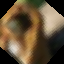

In [59]:
compose = v2.Compose([
    v2.RandomResizedCrop(size = (64, 64), antialias = True),
    v2.RandomRotation(degrees = (0, 90))
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (img) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(compose, examples["img"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

# Получение строки
print(dataset_train[1])
dataset_train[1]["pixel_values"]

#### Создание набора данных

> Разделение набора данных осуществляется по структуре корневой директории,
> а метки автоматически создаются из названий подкаталогов

$$
dataset/{train|test}/{class}/{filename}
$$

- ${train|test}$ — тренировочная, тестовая подвыборки
- ${class}$ — класс
- ${filename}$ — файл изображения или аудиозаписи

##### На основе директорий

Тренировочная подвыборка:
 Dataset({
    features: ['image', 'label'],
    num_rows: 13
}) 

Тестовая подвыборка:
 Dataset({
    features: ['image', 'label'],
    num_rows: 5
}) 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x361 at 0x14E576DE0>, 'label': 0, 'pixel_values': <PIL.Image.Image image mode=RGB size=128x128 at 0x14E574890>}


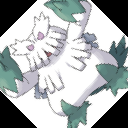

In [60]:
data_dir = os.path.join(".", "data", "pokemon") # Директория для загрузки набора данных

dataset = load_dataset(
    path = "imagefolder",
    data_dir = data_dir
)
dataset_train, dataset_test = dataset['train'], dataset['test']

compose = v2.Compose([
    v2.Resize(size = (128, 128), antialias = True)
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (image) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(lambda image: F.rotate(compose(image), angle = 45), examples["image"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test, "\n")

# Получение первой строки
print(dataset_train[0])

dataset_train[0]["pixel_values"]

##### На основе словаря

Тренировочная подвыборка:
 Dataset({
    features: ['image'],
    num_rows: 15
}) 

Тестовая подвыборка:
 Dataset({
    features: ['image'],
    num_rows: 7
}) 

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=360x325 at 0x14FA06BA0>, 'pixel_values': <PIL.Image.Image image mode=RGB size=128x128 at 0x14FA046E0>}


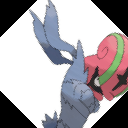

In [61]:
data_dir = os.path.join(".", "data", "pokemon") # Директория для загрузки набора данных

# Функция для получения путей к изображениям
def get_image_paths(data_dir, split):
    split_dir = Path(data_dir) / Path(split)
    return list(split_dir.rglob("*.jpg"))

# Пути к изображениям
train_images = get_image_paths(data_dir, "train")
test_images = get_image_paths(data_dir, "test")

dataset_train = Dataset.from_dict({"image": list(map(str, train_images))}).cast_column("image", Image())
dataset_test = Dataset.from_dict({"image": list(map(str, test_images))}).cast_column("image", Image())

compose = v2.Compose([
    v2.Resize(size = (128, 128), antialias = True)
])

def transforms(examples: dict):
    # Применение преобразований ко всем изображениям (image) и сохранение результатов (pixel_values)
    examples["pixel_values"] = list(map(lambda image: F.rotate(compose(image), angle = -45), examples["image"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(transforms)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test, "\n")

# Получение первой строки
print(dataset_train[0])

dataset_train[0]["pixel_values"]

#### Создание/чтение общей информации, хранящейся в [DatasetInfo](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetInfo)

In [62]:
dataset_info_dir = os.path.join(".", "data", "pokemon") # Директория с набором данных

dataset_train.info.write_to_directory(dataset_info_dir = dataset_info_dir)

ds_info = DatasetInfo.from_directory(dataset_info_dir = dataset_info_dir)

print(ds_info)

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None)}, post_processed=None, supervised_keys=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)


#### Добавление столбца

In [63]:
column = list(range(1, dataset_train.num_rows + 1))

new_dataset_train = dataset_train.add_column(name = "numbers", column = column)

new_dataset_train

Dataset({
    features: ['image', 'numbers'],
    num_rows: 15
})

#### Добавление строки

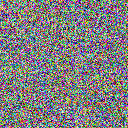

In [64]:
# Массив случайных пикселей
random_image_array = np.random.randint(0, 256, (128, 128, 3), dtype = np.uint8)
# Изображение из массива
random_image = PILImage.fromarray(random_image_array)

with io.BytesIO() as output:
    random_image.save(output, format = "PNG")
    image_bytes = output.getvalue()

new_item = {"image": image_bytes}

new_dataset_train = dataset_train.add_item(new_item)

new_dataset_train[-1]["image"]

#### Отображение структуры данных, которая хранится в виде таблицы Apache Arrow

In [65]:
dataset_train.data

InMemoryTable
image: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
----
image: [
  -- is_valid: all not null
  -- child 0 type: binary
[null,null,null,null,null,...,null,null,null,null,null]
  -- child 1 type: string
["data/pokemon/train/accelgor/0.jpg","data/pokemon/train/absol/2.jpg","data/pokemon/train/absol/1.jpg","data/pokemon/train/absol/0.jpg","data/pokemon/train/abra/2.jpg",...,"data/pokemon/train/abomasnow/2.jpg","data/pokemon/train/abomasnow/1.jpg","data/pokemon/train/abomasnow/0.jpg","data/pokemon/train/abra/.ipynb_checkpoints/0-checkpoint.jpg","data/pokemon/train/abra/.ipynb_checkpoints/1-checkpoint.jpg"]]

#### Количество столбцов/строк

##### Вариант 1

In [66]:
print("Количество столбцов:", dataset_train.num_columns)
print("Количество строк:", dataset_train.num_rows)

Количество столбцов: 1
Количество строк: 15


##### Вариант 2

In [67]:
print("Количество столбцов:", dataset_train.shape[1])
print("Количество строк:", dataset_train.shape[0])

Количество столбцов: 1
Количество строк: 15


#### Заголовки столбцов

In [68]:
new_dataset_train.column_names

['image']

### Построение и обучение простой нейросети для классификации данных

#### TensorBoard

In [69]:
# Запись событий в TensorBoard
# tensorboard --logdir=./tutorials/runs
log_dir = os.path.join(
    "runs", "CNN_LeNet" + "_" + "cifar10" + "_" + datetime.now().strftime("%b%d_%H-%M-%S") + "_" + socket.gethostname()
)
writer_tb = SummaryWriter(log_dir = log_dir)

#### Определение глобальных параметров

In [70]:
SEED = 10091991 # SEED

torch.manual_seed(SEED)
# Генератор случайных чисел
np.random.seed(SEED) 
random.seed(SEED)

ROOT_DIR = os.path.join(".")

PATH_TO_FONT = os.path.join(ROOT_DIR, "fonts", "SegoeUI.ttf") # Путь до шрифта
PATH_TO_MODEL = os.path.join(ROOT_DIR, "models") # Путь для сохранения моделей
PATH_TO_CACHE = os.path.join(ROOT_DIR, "data") # Путь для загрузки наборов данных

SIZE_IMG = (28, 28) # Размер изображений
SIZE_IMG_SHOW = (256, 256) # Размер изображений для отображения

#### Определение гиперпараметров для обучения

In [71]:
EPOCHS = 20 # Количество эпох
BATCH_SIZE = 32 # Размер выборки (пакета)
LEARNING_RATE = 1e-4 # Скорость обучения
ROUND_ACC = 2 # Знаков Accuracy после запятой
ROUND_LOSS = 7 # Знаков Loss после запятой
# Проверка наличия GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Формирование глобальных параметров для TensorBoard
learning_hyperparams = {
    "Гиперпараметр": [
        "Количество эпох", "Размер выборки (пакета)", "Скорость обучения",
        "Знаков Accuracy после запятой", "Знаков Loss после запятой",
        "Устройство для обучения"
    ],
    "Значение": [
        str(EPOCHS), BATCH_SIZE, LEARNING_RATE, ROUND_ACC, ROUND_LOSS, DEVICE
    ]
}

df_learning_hyperparams = pd.DataFrame(data = learning_hyperparams)
df_learning_hyperparams.index.name = "№"
df_learning_hyperparams.index += 1

display(df_learning_hyperparams)
# Отображение (TensorBoard)
writer_tb.add_text("Гиперпараметры для обучения", df_learning_hyperparams.to_markdown())

,Гиперпараметр,Значение
№,,
1,Количество эпох,20
2,Размер выборки (пакета),32
3,Скорость обучения,0.0001
4,Знаков Accuracy после запятой,2
5,Знаков Loss после запятой,7
6,Устройство для обучения,cpu


#### Формирование класса для обучения/тестирования/визуализации

In [72]:
@dataclass
class ModelTrainer:
    model: nn.Module # Нейросетевая модель
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    device: torch.device
    epochs: int
    round_loss: int
    round_acc: int

    optimizer: torch.optim
    
    patience: int = 5 # Ранняя остановка обучения

    # Возможные преобразования изображений
    cond_image_comps: ClassVar[List[str]] = ["img", "img_show", "img_train", "img_test"]

    # Компоновщики изображений
    composer_img: ClassVar[Optional[v2.Compose]] = None
    composer_img_show: ClassVar[Optional[v2.Compose]] = None

    class_names: ClassVar[Optional[List[str]]] = None # Список имен классов

    loss_fn: ClassVar[Optional[torch.nn.modules.loss]] = None

    writer_tb: ClassVar[Optional[SummaryWriter]] = None

    # Вызывается сразу после __init__ при использовании dataclass
    def __post_init__(self):
        # ----------------------- Только для внутреннего использования внутри класса
        
        # История обучения и тестирования
        self.__history = pd.DataFrame({
            "train_acc": [], # Точность на тренировочной выборке
            "test_acc": [], # Точность на тестовой выборке
            "train_loss": [], # Loss на тренировочной выборке
            "test_loss": [] # Loss на тестовой выборке
        })

        # Количество шагов в одной эпохе
        self.__train_steps = len(self.train_dataloader)
        self.__test_steps = len(self.test_dataloader)

        self.__best_test_accuracy = 0
        self.__no_improvement_count = 0

    @property
    def history(self) -> pd.DataFrame:
        """Получение DataFrame историей обучения и тестирования

        Returns:
            pd.DataFrame: **DataFrame** c историей обучения и тестирования
        """

        return self.__history
    
    @classmethod
    def create_image_composers(cls, condition: str, size: Tuple[int, int]) -> None:
        """Создание компоновщика изображений

        Args:
            condition (str): Какие преобразования применить к изображению
            size (Tuple[int, int]): Размер, к которому будет изменено изображение

        Raises:
            ValueError: Если передано недопустимое значение
        """
        
        try:
            if condition == cls.cond_image_comps[0]:
                cls.composer_img = v2.Compose([
                    v2.Resize(size = size, antialias = True),
                    v2.Grayscale(num_output_channels = 1)
                ])
            elif condition == cls.cond_image_comps[1]:
                cls.composer_img_show = v2.Compose([
                    v2.Resize(size = size, antialias = True)
                ])
            elif condition == cls.cond_image_comps[2]:
                cls.composer_img_show = v2.Compose([
                    v2.Resize(size = size, antialias = True)
                ])
            else:
                return None
        except ValueError:
            return None

    @classmethod
    def transforms_data(cls, examples: Dict[str, Any]) -> Dict[str, Any]:
        """Применение преобразований к выборкам

        Args:
            examples (Dict[str, Any]): Словарь с примерами

        Returns:
            Dict[str, Any]: Словарь с преобразованными примерами
        """

        if cls.composer_img:
            examples[cls.cond_image_comps[0]] = list(map(cls.composer_img, examples[cls.cond_image_comps[0]]))

        if cls.composer_img_show:
            examples[cls.cond_image_comps[1]] = list(map(cls.composer_img_show, examples[cls.cond_image_comps[0]]))

        try:
            examples["label_name"] = list(map(lambda label: cls.class_names[label], examples["label"]))
        except TypeError:
            pass

        return examples

    @classmethod
    def get_model_logits(cls, logits: torch.Tensor) -> torch.Tensor:
        """Получение логитов модели в зависимости от функции потерь

        Args:
            logits (torch.Tensor): Входные логиты

        Returns:
            torch.Tensor: Обработанные логиты
        """

        if isinstance(cls.loss_fn, nn.NLLLoss):
            log_softmax = nn.LogSoftmax(dim = 1)
            return log_softmax(logits)
        elif isinstance(cls.loss_fn, nn.CrossEntropyLoss):
            return logits

    def _is_best_model(self, test_accuracy: float) -> bool:
        """Проверка, является ли текущая модель лучшей на основе точности тестирования

        Args:
            test_accuracy (float): Текущая точность тестирования

        Returns:
            bool: True, если текущая модель лучшая, иначе False
        """

        try:
            max_test_acc = max(self.__history["test_acc"])
        except ValueError:
            max_test_acc = 0
        return test_accuracy > max_test_acc

    def _save_model(self, epoch: int, path_to_model: str, test_accuracy: float, loss: torch.Tensor) -> None:
        """Сохранение модели

        Args:
            epoch (int): Текущая эпоха
            path_to_model (str): Путь для сохранения модели
            test_accuracy (float): Точность на тестовой выборке
            loss (torch.Tensor): Значение потерь
        """
        
        os.makedirs(path_to_model, exist_ok = True)

        torch.save({
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "test_loss": loss,
        }, os.path.join(path_to_model, f"{model.__class__.__name__}_{epoch}_{test_accuracy}_checkpoint.pth"))

    @classmethod
    def visualize_samples_with_predictions(
        cls,
        model: nn.Module, # Нейросетевая модель
        device: torch.device,
        cid: datasets.Dataset,
        sample_name: str,
        path_to_font: str,
        cols: int = 10,
        rows: int = 3,
        fz: int = 40,
        pad: int = 10,
        outline_width: int = 0,
        border_thickness: int = 5,
        line_spacing: int = 5,
        seed: int = 42
    ) -> None:
        """Отображение примеров из указанной выборки
    
        Args:
            model (nn.Module): Нейросетевая модель
            device (torch.device): Устройство
            cid (datasets.Dataset): Выборка
            sample_name (str): Название выборки
            path_to_font (str): Путь до шрифта
            cols (int): Количество столбцов
            rows (int): Количество строк
            fz (int): Размер шрифта
            pad (int): Внутренний отступ для текста
            outline_width (int): Рамка огриничивающего прямоугольника текста
            border_thickness (int): Толщина рамки
            line_spacing (int): Отступ между строками
            seed (int): Начальное значение для генераторов
    
        Returns:
            None
        """
    
        font = ImageFont.truetype(path_to_font, size = fz)
    
        fig = plt.gcf() # Создание фигуры
        fig.set_size_inches(cols * 2.8, rows * 3.45) # Установка размера фигуры в дюймах
    
        img_batch = [] # Последовательность изображений
    
        # Случайные числа, которые выпали
        samples_idx = torch.randperm(len(cid), generator = torch.Generator().manual_seed(seed)).tolist()[:cols * rows]
        max_height_text = 0
    
        # Получение максимальной высоты текста
        for sample_idx in samples_idx:
            _, target, _, ntarget = cid[sample_idx].values() # Изображение и метка
            title = f"{target}: {ntarget}" # ID метки и метка
            # Размеры текста
            (_, height_text), _ = font.font.getsize(title)
            max_height_text = max(max_height_text, height_text)
        
        model.eval() if model else None # Установка модели в режим предсказаний
    
        for i, sample_idx in enumerate(samples_idx):    
            curr_cid = cid[sample_idx]
            if curr_cid is None: continue
    
            img_original, target, img_show, ntarget = curr_cid.values() # Изображение и метка
            title = f"{target}: {ntarget}" # ID метки и метка
    
            # Размеры текста
            (width_text, height_text), (offset_x, offset_y) = font.font.getsize(title)
            center_x = img_show.width // 2 # Ширина
            
            # Прозрачное наложение на текущий кадр
            img_transparent = PILImage.new(
                'RGBA',
                (img_show.width, img_show.height + max_height_text + pad * 2),
                (255, 255, 255, 0)
            )
    
            img_transparent.paste(img_show, (0, max_height_text + pad * 2))
    
            # Создание объекта, который можно использовать для рисования поверх изображения
            img_pil_obj = ImageDraw.Draw(img_transparent, 'RGBA')
    
            # Рисование прямоугольной области в виде фона текста на изображении
            img_pil_obj.rectangle(
                [(0, 0), (img_show.width, max_height_text + pad * 2)],
                fill = (255, 230, 204, 255),
                outline = (215, 154, 2, 255),
                width = outline_width
            )
    
            # Нанесение текста на кадр
            img_pil_obj.text(
                (int(center_x - width_text / 2), 0 - offset_y + pad),
                title,
                font = font,
                fill = (0, 0, 0, 255),
                stroke_width = 0,
                stroke_fill = (255, 255, 255, 255)
            )
    
            if model:
                # Предсказания на тестовой выборке
                with torch.no_grad():
                    img_original = v2.ToImage()(img_original).float().unsqueeze(0)
    
                    img_original = img_original.to(device)
    
                    logits = model(img_original) # Вектор необработанного (ненормализованного) прогноза
    
                    m_logits = cls.get_model_logits(logits)

                    try:
                        pred = torch.argmax(m_logits, dim = 1).item() # Предсказание
                    except:
                        logging.error(f"Логиты модели в зависимости от функции потерь не получены")
                        return
    
                    border_color = (0, 255, 0, 255) if target == pred else (255, 0, 0, 255)
                    
                    # Создаем изображение с размером на размер рамки
                    img_with_border = PILImage.new(
                        'RGBA',
                        (img_transparent.width + 2 * border_thickness, img_transparent.height + 2 * border_thickness),
                        (255, 255, 255, 0)
                    )
                    
                    # Рисуем красную рамку
                    draw = ImageDraw.Draw(img_with_border, 'RGBA')
                    draw.rectangle(
                        [(0, 0), (img_with_border.width, img_with_border.height)],
                        outline = border_color,
                        width = border_thickness
                    )
                    
                    # Вставляем исходное изображение с прозрачным фоном в центр рамки
                    img_with_border.paste(img_transparent, (border_thickness, border_thickness), img_transparent)
            else:
                img_with_border = img_transparent
    
            img_show = T.PILToTensor()(img_with_border.convert('RGB')) # PIL -> Tensor
    
            img_batch.append(img_show)
    
            fig.add_subplot(rows, cols, i + 1)
            plt.axis('off')
            plt.imshow(img_show.squeeze().permute(1, 2, 0))
        
        plt.subplots_adjust(wspace = 0, hspace = 0)
        plt.tight_layout(pad = line_spacing) # Установка расстояния между осями
        plt.show()
        
        img_batch = pad_sequence(img_batch).squeeze().permute(1, 0, 2, 3)
    
        # Создание сетки изображений
        img_grid = vutils.make_grid(img_batch, nrow = 10)

        try:
            cls.writer_tb.add_image(f'Примеры из {sample_name} выборки', img_grid, seed)
        except:
            logging.error(f"Объкт для записи событий в TensorBoard не найден")
    
    # Процесс обучения
    def train(self, path_to_model: str) -> None:
        """Процесс обучения

        Args:
            path_to_model (str): Путь для сохранения моделей

        Returns:
            None
        """
        
        self.model.train() # Установка модели в режим обучения

        for epoch in range(1, self.epochs + 1):
            # Сумма Loss
            total_train_loss = 0
            total_test_loss = 0
            # Сумма точности
            train_accuracy = 0
            test_accuracy = 0

            # Проход по всем тренировочным пакетам
            with tqdm.tqdm(total = self.__train_steps, desc = f"Эпоха {epoch}", unit = "batch") as pbar_train:
                for batch, (imgs, targets) in enumerate(self.train_dataloader, 1):
                    # Перемещение данных на нужное устройство
                    imgs, targets = imgs.to(self.device), targets.to(self.device)

                    logits = self.model(imgs) # Пакет векторов необработанных (ненормализованных) предсказаний
                    m_logits = self.get_model_logits(logits)

                    loss = self.loss_fn(m_logits, targets) # Ошибка предсказаний

                    # Обратное распространение для обновления весов
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
        
                    total_train_loss += loss.item() # Потеря
                    # Количество правильных предсказаний
                    train_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                    pbar_train.update(1)

                # Средняя потеря
                avg_train_loss = round(total_train_loss / batch, self.round_loss)
                self.writer_tb.add_scalar("Средняя потеря/тренировочная", avg_train_loss, epoch)
        
                # Точность
                train_accuracy = round(train_accuracy / len(self.train_dataloader.dataset) * 100, self.round_acc)
                self.writer_tb.add_scalar("Точность/тренировочная", train_accuracy, epoch)
        
                pbar_train.set_postfix({
                    "Точность": train_accuracy,
                    "Средняя потеря": avg_train_loss
                })

            # Установка модели в режим предсказаний
            self.model.eval()
        
            # Предсказания на тестовой выборке
            with torch.no_grad():
                with tqdm.tqdm(total = self.__test_steps, desc = f"Тестирование {epoch}", unit = "batch") as pbar_test:
                    # Проход по всем тестовым пакетам
                    for batch, (imgs, targets) in enumerate(self.test_dataloader, 1):
                        # Перемещение данных на нужное устройство
                        imgs, targets = imgs.to(self.device), targets.to(self.device)
        
                        logits = self.model(imgs) # Пакет векторов необработанных (ненормализованных) прогнозов
                        m_logits = self.get_model_logits(logits)
                            
                        loss = self.loss_fn(m_logits, targets) # Ошибка предсказаний
                        
                        total_test_loss += loss.item() # Потеря
                        # Количество правильных предсказаний
                        test_accuracy += (logits.argmax(1) == targets).type(torch.float).sum().item()
        
                        pbar_test.update(1)

                    # Средняя потеря
                    avg_test_loss = round(total_test_loss / batch, self.round_loss)
                    self.writer_tb.add_scalar("Средняя потеря/тестовая", avg_test_loss, epoch)
        
                    # Точность
                    test_accuracy = round(test_accuracy / len(self.test_dataloader.dataset) * 100, self.round_acc)
                    self.writer_tb.add_scalar("Точность/тестовая", test_accuracy, epoch)
                    
                    pbar_test.set_postfix({
                        "Точность": test_accuracy,
                        "Средняя потеря": avg_test_loss
                    })
            
            if self._is_best_model(test_accuracy):
                self._save_model(epoch, path_to_model, test_accuracy, avg_test_loss)
                self.__best_test_accuracy = test_accuracy
                self.__no_improvement_count = 0
            else:
                self.__no_improvement_count += 1

            # Добавлениие данных в историю обучения
            new_row = pd.Series([train_accuracy, test_accuracy, avg_train_loss, avg_test_loss], index = self.__history.columns)
            self.__history = pd.concat([self.__history, new_row.to_frame().T], ignore_index = True)

            if self.__no_improvement_count >= self.patience:
                logging.info(f"Ранняя остановка на эпохе {epoch} из-за отсутствия улучшения точности на тестовой выборке")
                break

    # Получение хэш-значения
    def __hash__(self):
        return id(self)

#### Формирование архитектуры нейросетевой модели

In [73]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

#### Загрузка набора данных из [Hugging Face Hub](https://huggingface.co/datasets)

> Перед загрузкой набора данных можно получить общую информацию, хранящуюся в [DatasetInfo](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.DatasetInfo), включая описание, функции и размер набора данных

In [74]:
dataset_train, dataset_test = load_dataset(
    path = "uoft-cs/cifar10",
    name = "plain_text", # смотреть configs
    split = dataset_split_names,
    cache_dir = PATH_TO_CACHE,
    trust_remote_code = True
)

print("Тренировочная подвыборка:\n", dataset_train, "\n")
print("Тестовая подвыборка:\n", dataset_test)

Тренировочная подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 50000
}) 

Тестовая подвыборка:
 Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})


In [75]:
ModelTrainer.create_image_composers("img", SIZE_IMG)
ModelTrainer.create_image_composers("img_show", SIZE_IMG_SHOW)

ModelTrainer.class_names = ds_builder.info.features["label"].names

# Применение функции transforms для тренировочной подвыборки
dataset_train.set_transform(ModelTrainer.transforms_data)
# Применение функции transforms для тестовой подвыборки
dataset_test.set_transform(ModelTrainer.transforms_data)

# Получение строки
print(dataset_train[1])
print(dataset_test[1])

{'img': <PIL.Image.Image image mode=L size=28x28 at 0x14AC76DE0>, 'label': 6, 'img_show': <PIL.Image.Image image mode=L size=256x256 at 0x14F9D7890>, 'label_name': 'frog'}
{'img': <PIL.Image.Image image mode=L size=28x28 at 0x14FA07950>, 'label': 8, 'img_show': <PIL.Image.Image image mode=L size=256x256 at 0x14F9D6CF0>, 'label_name': 'ship'}


#### Визуализация архитектуры нейросети

In [76]:
input_size = (BATCH_SIZE, *list(v2.ToTensor()(dataset_train[0]["img"]).shape))

# Создание экземпляра модели
model = LeNet().to(DEVICE)

summary(
    model = model,
    input_size = input_size,
    col_names = ["input_size", "output_size", "num_params", "params_percent", "mult_adds", "trainable"],
    col_width = 15,
    mode = "train",
    verbose = 0,
    device = DEVICE
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Param %         Mult-Adds       Trainable
LeNet                                    [32, 1, 28, 28] [32, 10]        --                   --         --              True
├─Conv2d: 1-1                            [32, 1, 28, 28] [32, 6, 24, 24] 156               0.35%         2,875,392       True
├─ReLU: 1-2                              [32, 6, 24, 24] [32, 6, 24, 24] --                   --         --              --
├─MaxPool2d: 1-3                         [32, 6, 24, 24] [32, 6, 12, 12] --                   --         --              --
├─Conv2d: 1-4                            [32, 6, 12, 12] [32, 16, 8, 8]  2,416             5.44%         4,947,968       True
├─ReLU: 1-5                              [32, 16, 8, 8]  [32, 16, 8, 8]  --                   --         --              --
├─MaxPool2d: 1-6                         [32, 16, 8, 8]  [32, 16, 4, 4]  --                   --         --            

#### Примеры из тренировочной подвыборки

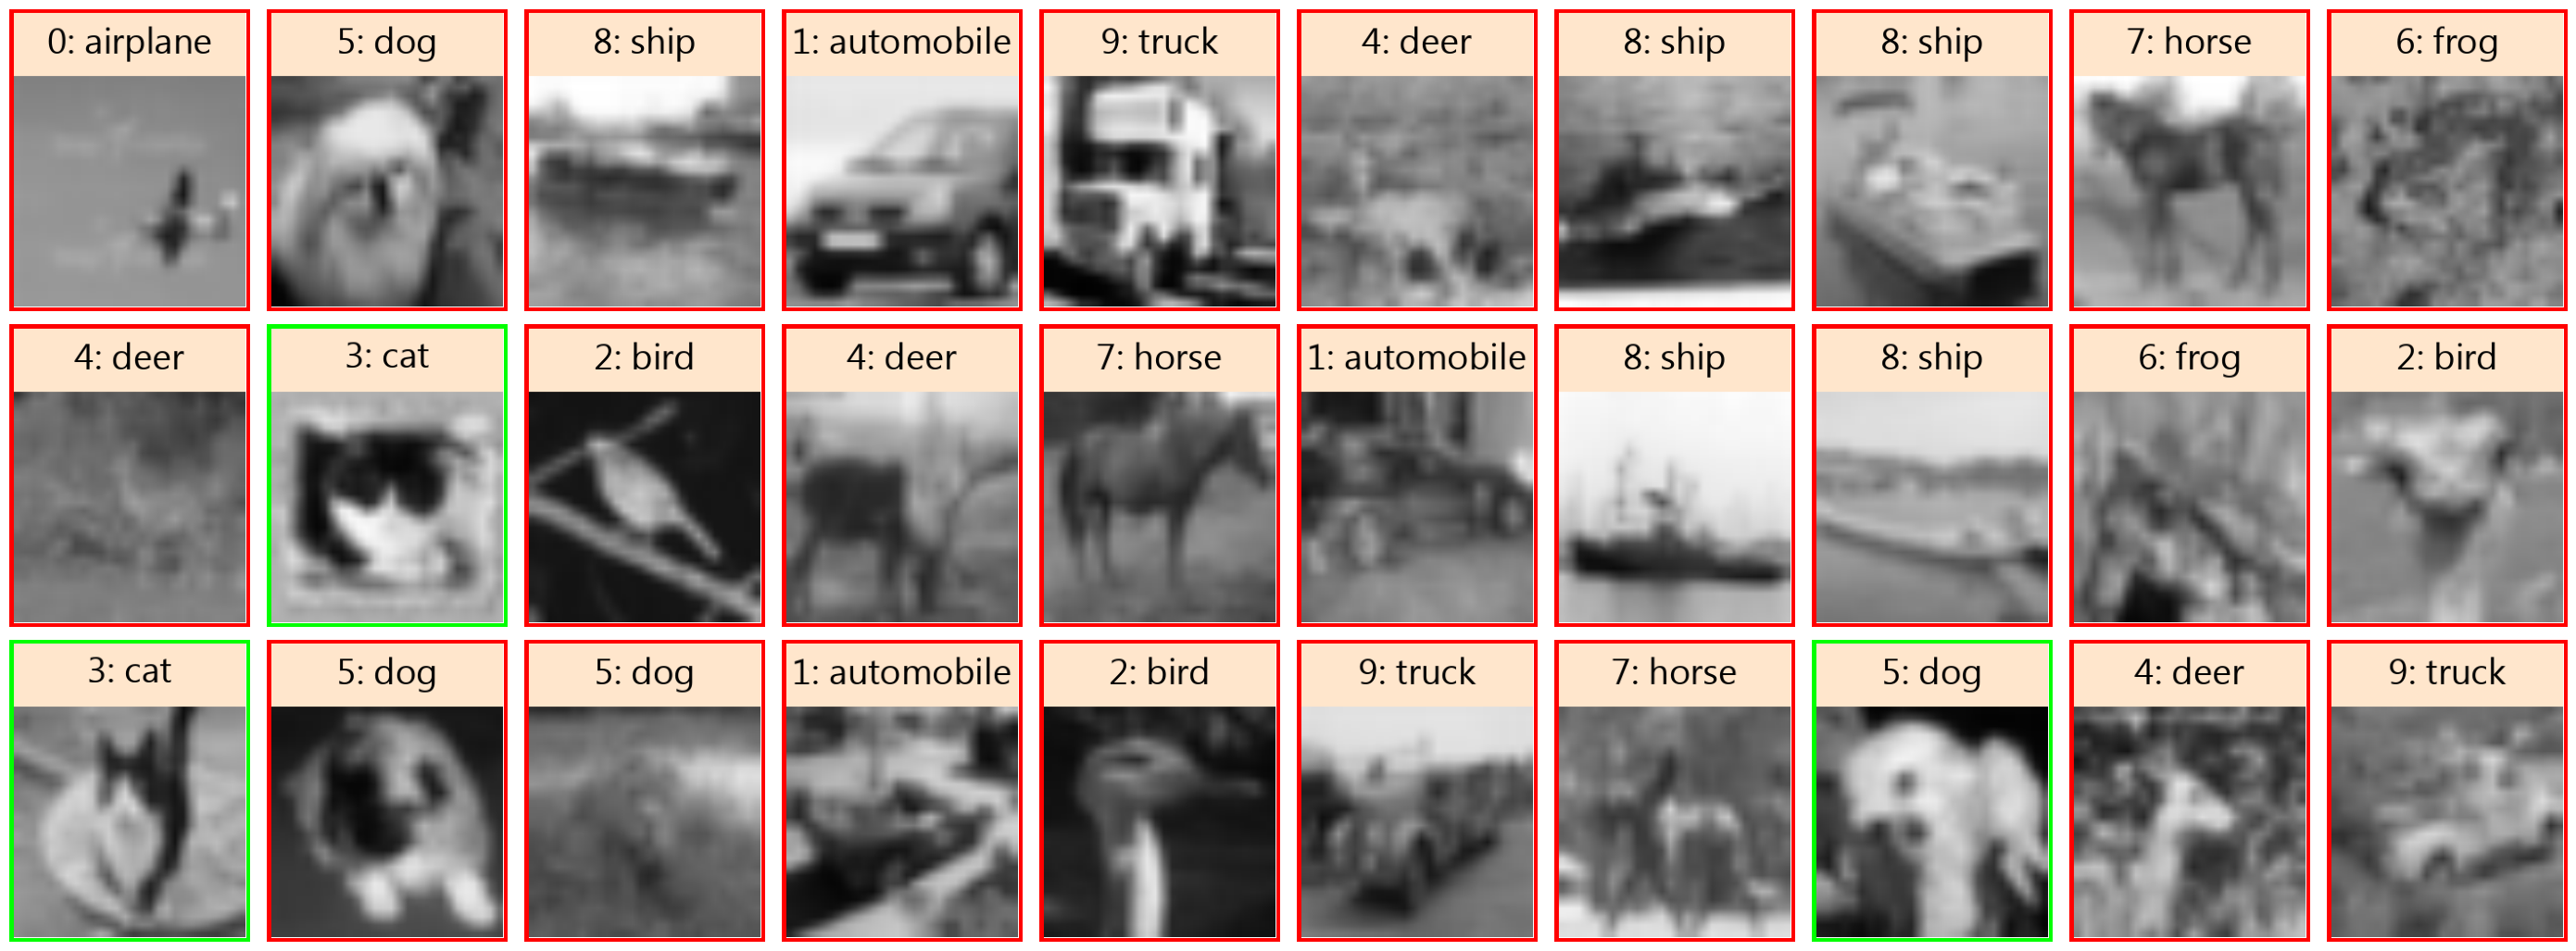

In [77]:
# Функция потерь (стоимость ошибок предсказаний)
ModelTrainer.loss_fn = nn.NLLLoss(reduction = "mean")
ModelTrainer.writer_tb = writer_tb

# Отображение примеров из обучающей выборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_train,
    sample_name = "тренировочной",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 40,
    pad = 15,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

#### Примеры из тестовой подвыборки

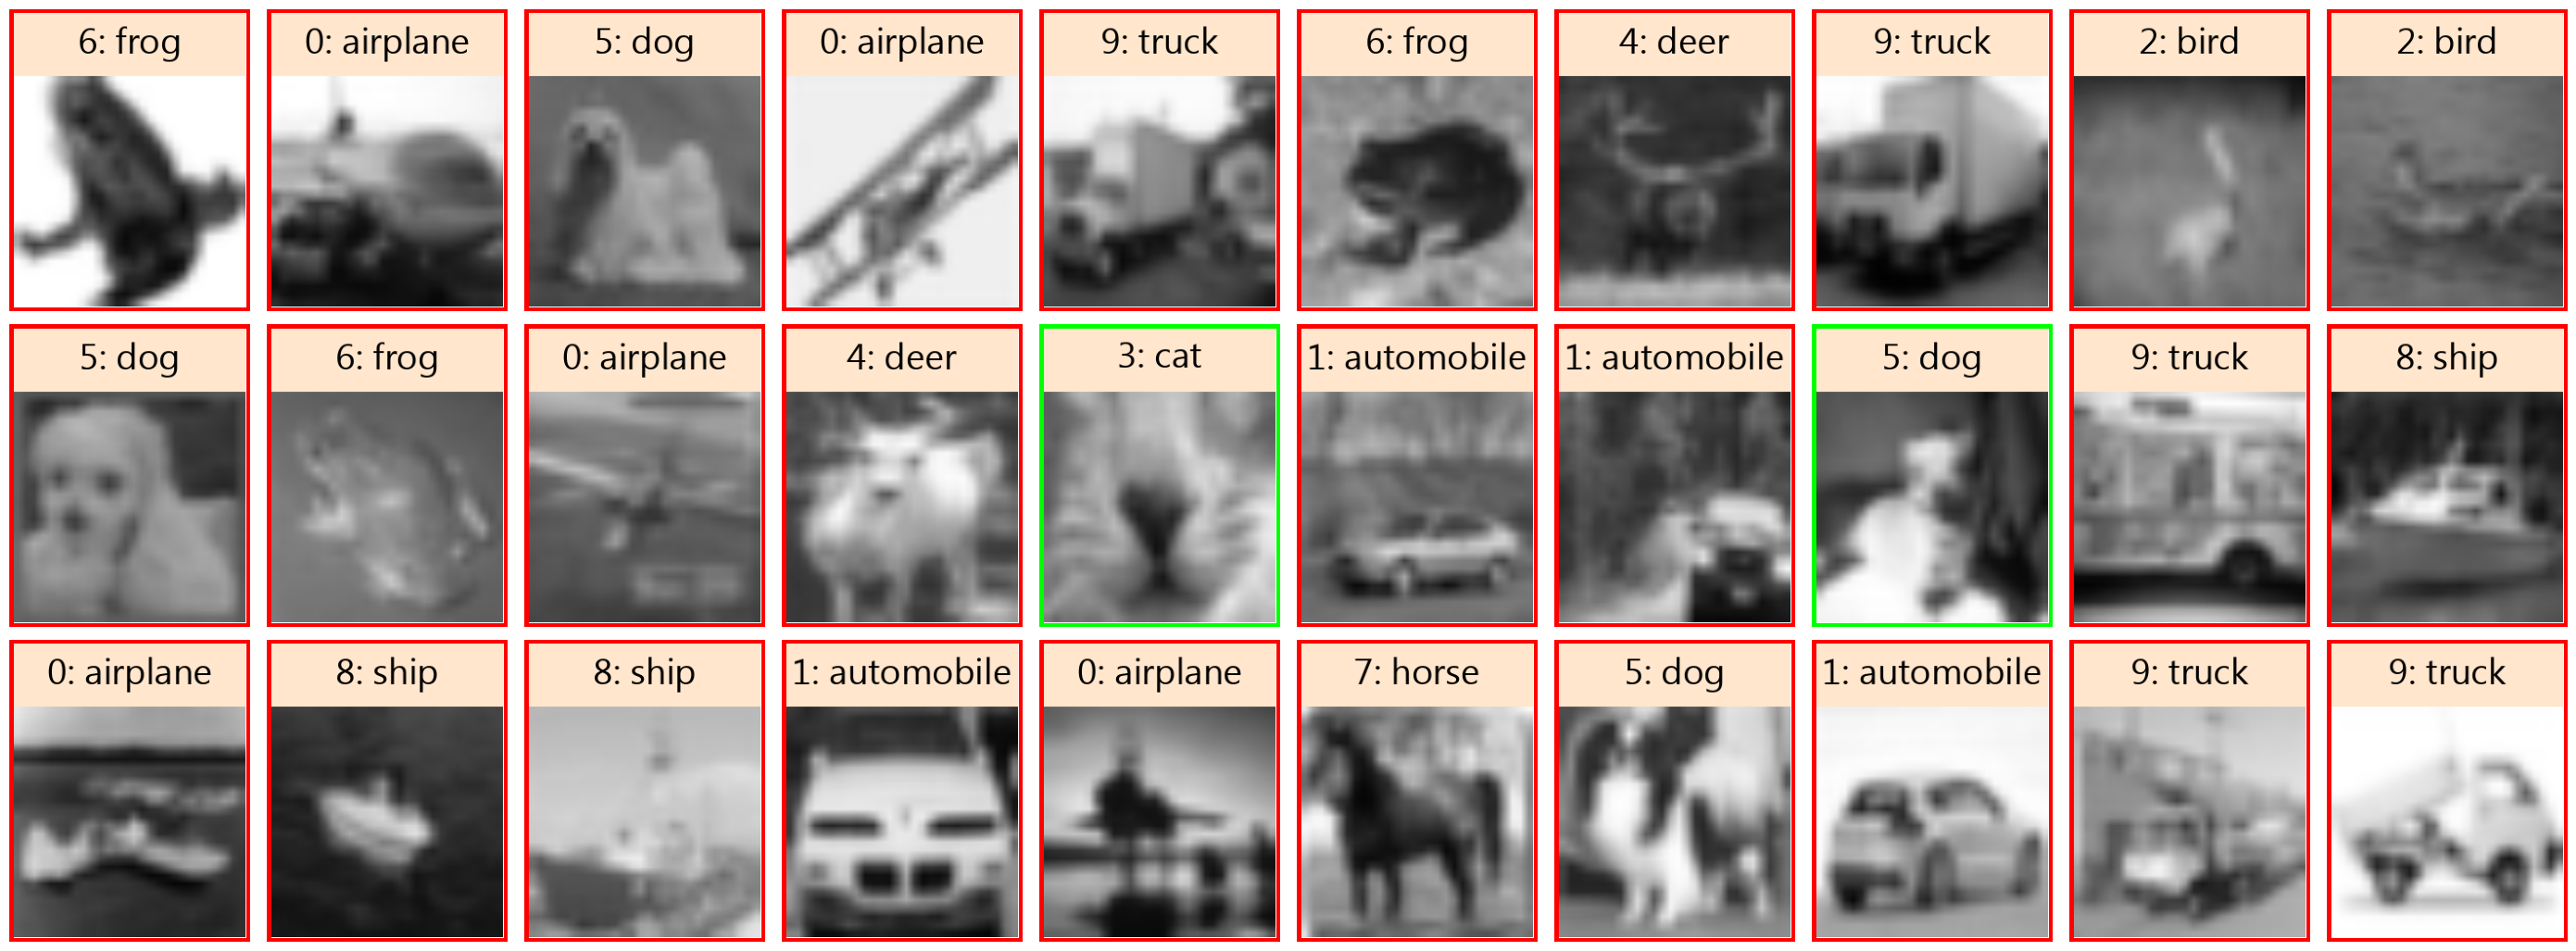

In [78]:
# Функция потерь (стоимость ошибок предсказаний)
ModelTrainer.loss_fn = nn.NLLLoss(reduction = "mean")
ModelTrainer.writer_tb = writer_tb

# Отображение примеров из тестовой поддвыборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_test,
    sample_name = "тестовой",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 40,
    pad = 15,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

#### Форматирование данных выбранных столбцов в указанный тип

In [79]:
dataset_format_train = dataset_train.with_format(type = "torch", columns = ["img", "label"])
dataset_format_test = dataset_test.with_format(type = "torch", columns = ["img", "label"])

#### Информация о наборе данных

In [80]:
train_label_counts = list(Counter(dataset_format_train["label"].tolist()).values())
test_label_counts = list(Counter(dataset_format_test["label"].tolist()).values())
all_label_counts = np.add(train_label_counts, test_label_counts).tolist()

train_label_sum = sum(train_label_counts)
test_label_sum = sum(test_label_counts)
all_label_sum = sum(all_label_counts)

# Формирование информации о наборе данных для TensorBoard
dataset_info = {
    "№" : [i + 1 for i in range(len(ds_builder.info.features["label"].names))],
    "Имя класса": ds_builder.info.features["label"].names,
    "ID класса": torch.unique(dataset_format_train["label"], return_inverse = True)[0].tolist(),
    "Тренировочная выборка (%)": train_label_counts,
    "Тестовая выборка (%)": test_label_counts,
    "Всего (%)": list(map(lambda val: f'{val} ({round(val * 100 / all_label_sum, 3)})', all_label_counts))
}

df_dataset_info = pd.DataFrame(data = dataset_info)
df_dataset_info.loc[df_dataset_info.shape[0]] = [
    '', '', '',
    f'{train_label_sum} ({round(train_label_sum * 100 / all_label_sum, 3)})',
    f'{test_label_sum} ({round(test_label_sum * 100 / all_label_sum, 3)})',
    all_label_sum
]
df_dataset_info.set_index("№", inplace = True)

display(df_dataset_info) # Отображение
# Отображение (TensorBoard)
writer_tb.add_text('Информация о наборе данных и его подвыборках', df_dataset_info.to_markdown())

,Имя класса,ID класса,Тренировочная выборка (%),Тестовая выборка (%),Всего (%)
№,,,,,
1,airplane,0,5000,1000,6000 (10.0)
2,automobile,1,5000,1000,6000 (10.0)
3,bird,2,5000,1000,6000 (10.0)
4,cat,3,5000,1000,6000 (10.0)
5,deer,4,5000,1000,6000 (10.0)
6,dog,5,5000,1000,6000 (10.0)
7,frog,6,5000,1000,6000 (10.0)
8,horse,7,5000,1000,6000 (10.0)
9,ship,8,5000,1000,6000 (10.0)


#### Применение преобразований

In [81]:
try:
    compose_img = v2.Compose([
        v2.ToImage(),
        v2.Resize(size = SIZE_IMG, antialias = True),
        v2.Grayscale(num_output_channels = 1)
    ])
except ValueError:
    compose_img = None

def transforms_format_train(examples: dict):
    if compose_img:
        # Применение преобразований ко всем изображениям (img) и сохранение результатов (img)
        examples["img"] = list(map(compose_img, examples["img"]))

    return examples # Результат

def transforms_format_test(examples: dict):
    if compose_img:
        # Применение преобразований ко всем изображениям (img) и сохранение результатов (img)
        examples["img"] = list(map(compose_img, examples["img"]))

    return examples # Результат

# Применение функции transforms для тренировочной подвыборки
dataset_format_train.set_transform(transforms_format_train)
# Применение функции transforms для тестовой подвыборки
dataset_format_test.set_transform(transforms_format_test)

#### Упаковка данных в пакеты

In [82]:
gen = torch.Generator() # Генератор
gen.manual_seed(SEED)

# Изменение последовательности для загрузчика
def collate_batch(batch):
    imgs = list(map(lambda item: item["img"].float(), batch))
    targets = list(map(lambda item: item["label"], batch))

    imgs = pad_sequence(imgs, batch_first = True)
    targets = torch.tensor(targets)

    return imgs.squeeze().unsqueeze(0).permute(1, 0, 2, 3), targets

train_dataloader = DataLoader(
    dataset_format_train, batch_size = BATCH_SIZE, generator = gen, shuffle = True, drop_last = False, collate_fn = collate_batch
)
test_dataloader = DataLoader(
    dataset_format_test, batch_size = BATCH_SIZE, generator = gen, shuffle = False, drop_last = False, collate_fn = collate_batch
)

# N - количество (размер выборки), C - канал, H - высота, W - ширина
train_dataiter = iter(train_dataloader)
img, target = next(train_dataiter)
print("Размер пакета с тренировочными изображениями [N, C, H, W]:", img.shape)
print("Метки:", target.shape, target.dtype)
    
# N - количество (размер выборки), C - канал, H - высота, W - ширина
test_dataiter = iter(test_dataloader)
img, target = next(test_dataiter)
print("Размер пакета с тестовыми изображениями [N, C, H, W]:", img.shape)
print("Метки:", target.shape, target.dtype)

Размер пакета с тренировочными изображениями [N, C, H, W]: torch.Size([32, 1, 28, 28])
Метки: torch.Size([32]) torch.int64
Размер пакета с тестовыми изображениями [N, C, H, W]: torch.Size([32, 1, 28, 28])
Метки: torch.Size([32]) torch.int64


### Обучение нейросетевой модели

> Для повторения результатов необходимо перезапустить `Kernel`

In [83]:
logging.basicConfig(level = logging.INFO)

# Оптимизация параметров нейросетевой модели для минимизации функции потерь
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)
# Функция потерь (стоимость ошибок предсказаний)
loss_fn = nn.NLLLoss(reduction = "mean")

trainer = ModelTrainer(model, train_dataloader, test_dataloader, DEVICE, EPOCHS, ROUND_LOSS, ROUND_ACC, optimizer)

trainer.train(PATH_TO_MODEL)

Тестирование 20: 100%|█████████████████████████| 313/313 [00:07<00:00, 44.71batch/s, Точность=46.6, Средняя потеря=1.65]


#### Загрузка и тестирование нейросетевой модели

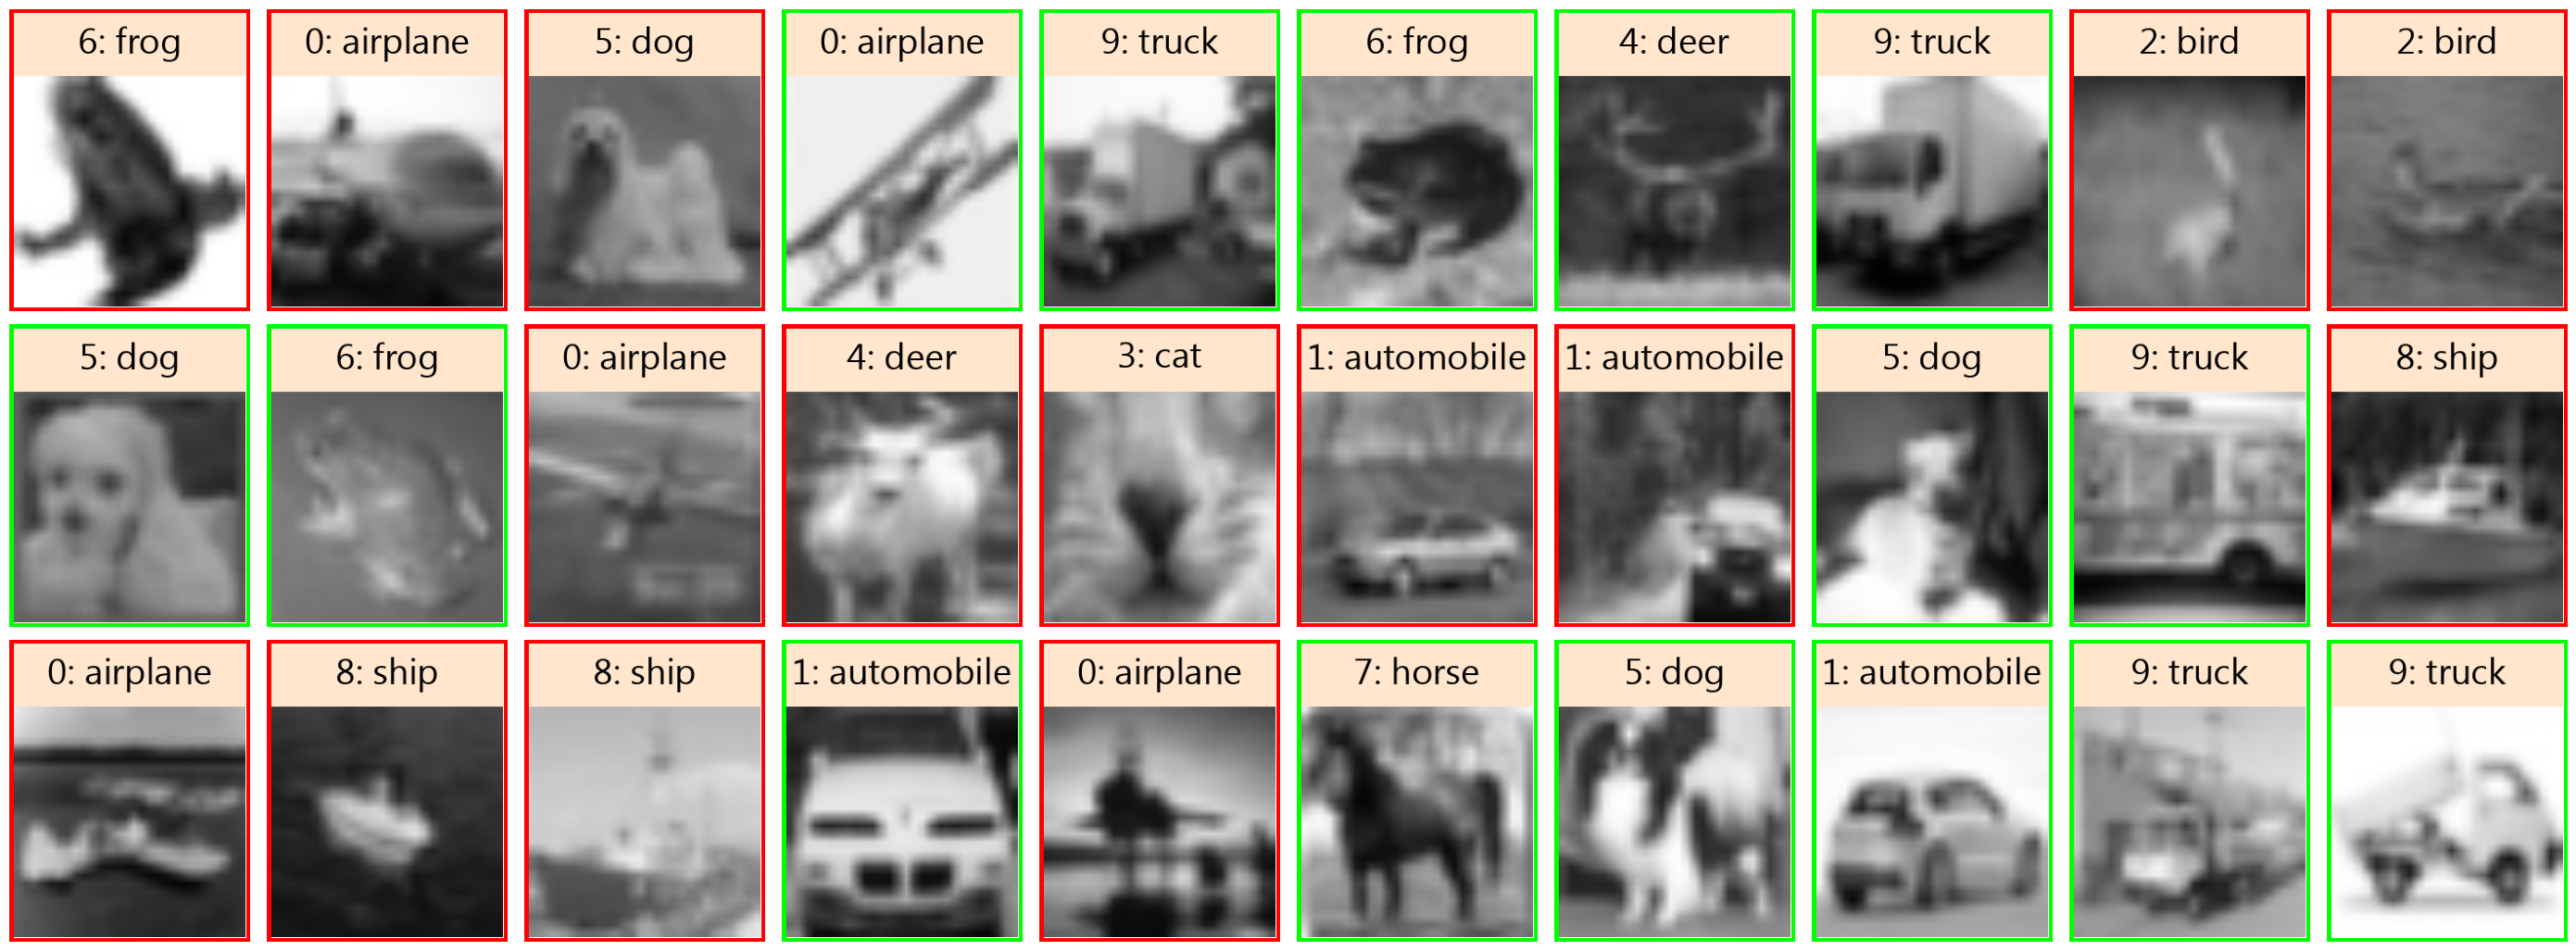

In [100]:
# Создание экземпляра модели
model = LeNet().to(DEVICE)

checkpoint = torch.load(os.path.join(PATH_TO_MODEL, "LeNet_20_46.24_checkpoint.pth"))
model.load_state_dict(checkpoint['model_state_dict'])

# Отображение примеров из тестовой поддвыборки
ModelTrainer.visualize_samples_with_predictions(
    model = model,
    device = DEVICE,
    cid = dataset_test,
    sample_name = "тестовой",
    path_to_font = PATH_TO_FONT,
    cols = 10,
    rows = 3,
    fz = 40,
    pad = 15,
    outline_width = 0,
    border_thickness = 5,
    line_spacing = 1,
    seed = SEED
)

## Домашнее задание  

### Работа с набором данных Complete Pokemon Image Dataset

Необходимо выполнить полный цикл подготовки, обучения и оценки нейросетевой модели на наборе данных [Complete Pokemon Image Dataset](https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset/data)

#### Задачи  

1. **Загрузка данных**
    - Скачать данные набора **Complete Pokemon Image Dataset** с платформы Kaggle
2. **Создание набора данных с использованием библиотеки `datasets`**  
    - Использовать библиотеку `datasets` для обработки данных:  
        - Преобразовать данные в формат `datasets.Dataset`
        - Реализовать логику загрузки данных на основе директорий или словаря
3. **Создание нейросетевой модели**  
    - Построить архитектуру нейронной сети для задачи классификации с помощью `torch.nn`
4. **Обучение модели**  
    - Разделить данные на обучающую и тестовую выборки
    - Реализовать процесс обучения модели, сохраняя метрики (точность, ошибка и т.д.) и визуализации в `TensorBoard`
5. **Оценка результатов**  
    - Выполнить предсказания на тестовой и обучающей выборках
    - Визуализировать
        - Графики метрик обучения (точность, ошибка и т.д.)
        - Правильные и ошибочные предсказания
6. **Сохранение лучшей модели**  
    - Сохранить обученную модель в формате `state_dict` или аналогах
7. **Демонстрация работы модели**
    - Загрузить сохраненную модель
    - Показать визуализацию предсказаний модели на новых данных с указанием вероятностей классов
8. **Выводы**
    - Какие процессы не работают?
    - Какие проблемы были решены?
    - Какие метрики достигнуты?
    - Какие улучшения могли бы быть добавлены?